In [3]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import os


class Config:

    PROJECT_DIR = os.environ["PWD"]
    DATA_DIR = os.getenv("DATA_DIR", "dat/")
    RESULTS_DIR = os.getenv("RESULTS_DIR", "results/")
    MODELS_DIR = os.getenv("MODELS_DIR", "models/")
    CHECKPOINT_DIR = os.getenv("CHECKPOINT_DIR", "models/checkpoint/")
    LOGS_DIR = os.getenv("LOGS_DIR", "logs/")

In [4]:
def print_stats(X, y, num_s, num_e, ratio):
    print('Stats:')
    print("------------------------")
    print("------------------------")
    print(f'N(X) == N(y) == {len(y)}')
    print(f'errs: {num_e}')
    print(f'Clean data (N = {num_s}) ratio: {ratio}%')
    print("------------------------")

# Data Loading

In [5]:
config = Config()

X_train_dir = f"{config.DATA_DIR}clean/"
y_train_dir = f"{config.DATA_DIR}trans/"
X_test_dir = f"{config.DATA_DIR}test/"

# Will notify if these values change
max_encoder_seq_length = 81
max_decoder_seq_length = 162

In [6]:
import string

table = str.maketrans(dict.fromkeys(string.punctuation))

# All of the characters and substring that would mark lines in the training data as "faulty"
invalid_chars = set(
    [
        ":",
        "+",
        "#",
        "@",
        "Ö",
        "á",
        "ä",
        "é",
        "í",
        "ñ",
        "ó",
        "ö",
        "ú",
        "ā",
        "Ć",
        "ć",
        "ʻ",
        "́",
        "е",
        "н",
        "о",
        "п",
        "у",
        "ш",
        "ã",
        "ï",
        "ō",
        "ū",
        "ί",
        "α",
        "δ",
        "ε",
        "κ",
        "ο",
        "в",
        "ὐ",
        chr(776),
        "ç",
        "ē",
        "D",
        "O",
        "T",
    ]
)
invalid_chars_X = set(["(", ")", "<", ">", "_", ","])
invalid_markers = set(["\\F", "TrueP", "\\x", "semantics_error", "Prog("])
files_with_compound_preds = [20, 21, 15]


def mark_if_faulty(line, file_idx, X=False):
    if X and (
        any((c in invalid_chars) for c in line)
        or any((c in invalid_chars_X) for c in line)
    ):
        return "syntax_error"
    # TODO: Refactor this hacky workaround
    if line[0] == "(" and file_idx not in files_with_compound_preds:
        return "syntax_error"
    if any((m in line) for m in invalid_markers) or any(
        (c in invalid_chars) for c in line
    ):
        return "syntax_error"
    # Remove top-level parentheses from lambda expression
    if line[0:4] == "(exi" and line[-1] == ")":
        line = line[1:-1]
    if line[0:4] == "(all" and line[-1] == ")":
        line = line[1:-1]

    return line


def lines_from_file(direc, name, drop_punc=False, lower=True, drop_fullstop=True):
    with open(direc + name) as f:
        for l in f:
            l = l.rstrip()
            if drop_punc:
                l = l.translate(table)
            if lower:
                l = l.lower()
            if drop_fullstop and not drop_punc:
                l = l[0:-1]
            yield l


def load_and_clean_data(start_idx=1, end_idx=17, skip_idx_list=None):
    X, y = [], []

    err = lambda x: x == "syntax_error"
    X_name = lambda i: f"concordance_{i}_clean.txt"
    y_name = lambda i: f"concordance_{i}_clean.lam"

    # Load lines from files and mark those that are "faulty"
    for i in range(start_idx, end_idx + 1):
        if i in skip_idx_list:
            continue

        X = X + [
            mark_if_faulty(line, i, True)
            for line in lines_from_file(X_train_dir, X_name(i), drop_fullstop=True)
        ]
        y = y + [
            mark_if_faulty(line, i)
            for line in lines_from_file(
                y_train_dir, y_name(i), lower=False, drop_fullstop=False
            )
        ]

    # Save "faulty" line indices
    err_idx_X = [i1 for i1 in range(len(X)) if err(X[i1])]
    err_idx_y = [j1 for j1 in range(len(X)) if err(y[j1])]

    err_idx = set(err_idx_X).union(set(err_idx_y))
    num_err = len(err_idx)
    num_samples = len(y) - num_err
    clean_ratio = 100 - ((num_err / len(y)) * 100)

    # Show stats about training data
    print_stats(X, y, num_samples, num_err, clean_ratio)

    # Remove "faulty" lines
    for index in sorted(list(err_idx), reverse=True):
        del X[index]
        del y[index]

    return (X, y)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    *load_and_clean_data(1, 23, [8, 6]), test_size=0.25, random_state=4, shuffle=True
)


Stats:
------------------------
------------------------
N(X) == N(y) == 103847
errs: 10599
Clean data (N = 93248) ratio: 89.79363871849932%
------------------------


# Preprocessing

In [8]:
# Vectorize the data.
input_characters = set()
target_characters = set()

for i in range(0, len(X_train)):
    # SOS == '\n'
    # EOS == '\t'
    y_train[i] = "\t" + y_train[i] + "\n"

    for char in X_train[i]:
        if char not in input_characters:
            input_characters.add(char)
    for char in y_train[i]:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_X_len = max([len(txt) for txt in X_train])
max_y_len = max([len(txt) for txt in y_train])

print("Number of samples:", len(X_train))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

if max_X_len > max_encoder_seq_length:
    print("WARNING: NEW Max sequence length for inputs:", max_X_len)
    print("Dataset may be incompatible with older models.")
    max_encoder_seq_length = max_X_len

if max_y_len > max_decoder_seq_length:
    print("WARNING: NEW Max sequence length for outputs:", max_y_len)
    print("Dataset may be incompatible with older models.")
    max_decoder_seq_length = max_y_len

print(target_characters)


Number of samples: 69936
Number of unique input tokens: 39
Number of unique output tokens: 50
['\t', '\n', ' ', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '>', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


In [9]:
# char to index
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(X_train), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(X_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(X_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)


In [10]:
import sys

np.set_printoptions(threshold=10)

for i, (input_text, target_text) in enumerate(zip(X_train, y_train)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

encoder_input_data[0]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Write Test Data (Optional)

In [11]:
# import datetime

# with open(X_test_dir + f"{datetime.datetime()}_X_test.txt", 'w+') as f:
#     for line in X_test:
#         f.write(f"{line}\n")
        
# with open(X_test_dir + f"{datetime.datetime()}_y_test.txt", 'w+') as f:
#     for line in y_test:
#         f.write(f"{line}\n")

# ML Pipeline Set-up

In [12]:
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(
            name="W_a",
            shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
            initializer="uniform",
            trainable=True,
        )
        self.U_a = self.add_weight(
            name="U_a",
            shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
            initializer="uniform",
            trainable=True,
        )
        self.V_a = self.add_weight(
            name="V_a",
            shape=tf.TensorShape((input_shape[0][2], 1)),
            initializer="uniform",
            trainable=True,
        )

        super(AttentionLayer, self).build(
            input_shape
        )  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print("encoder_out_seq>", encoder_out_seq.shape)
            print("decoder_out_seq>", decoder_out_seq.shape)

        def energy_step(inputs, states):
            """Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(
                states, type(states)
            )
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(
                K.dot(inputs, self.U_a), 1
            )  # <= batch_size, 1, latent_dim
            if verbose:
                print("Ua.h>", U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print("Ws+Uh>", Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print("ei>", e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(
                states, type(states)
            )
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print("ci>", c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(
            encoder_out_seq, axis=2
        )  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step,
            decoder_out_seq,
            [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step,
            e_outputs,
            [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1])),
        ]


In [13]:
from tensorflow.keras.layers import (
    Input,
    LSTM,
    GRU,
    Dense,
    Concatenate,
    TimeDistributed,
    Bidirectional,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from livelossplot import PlotLossesKeras


# Model Architecture

### Vanilla LSTM (Sutskever et al.)

In [14]:
latent_dim = 256
batch_size = 64  # Batch size for training.
epochs = 300  # Number of epochs to train for.
simple_name = "lstm"

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(
    latent_dim, recurrent_dropout=0.1, return_state=True, name="encoder"
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(
    latent_dim,
    recurrent_dropout=0.1,
    return_sequences=True,
    return_state=True,
    name="decoder",
)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_pred = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)

full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)


2022-10-05 01:48:04.485983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Simple GRU

In [15]:
latent_dim = 96
batch_size = 64  # Batch size for training.
epochs = 300  # Number of epochs to train for.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, recurrent_dropout=0.333, return_state=True, name="encoder")
encoder_outputs, encoder_state = encoder(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(
    latent_dim,
    recurrent_dropout=0.2,
    return_sequences=True,
    return_state=True,
    name="decoder",
)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_pred = decoder_dense(decoder_outputs)

early_stop = EarlyStopping(patience=3, monitor="val_loss")

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)

full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)


### Bidirectional GRU + Attention

In [16]:
latent_dim = 48
batch_size = 64  # Batch size for training.
epochs = 30  # Number of epochs to train for.
recurrent_dropout_rate = 0.2
dropout_rate = 0.5
simple_name = "bigru"

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# Encoder GRU
encoder_gru = Bidirectional(
    GRU(
        latent_dim,
        return_sequences=True,
        return_state=True,
        name="encoder_gru",
        recurrent_dropout=recurrent_dropout_rate,
    ),
    name="bidirectional_encoder",
)
encoder_out, encoder_fwd_state, encoder_back_state = encoder_gru(encoder_inputs)

# Set up the decoder GRU, using `encoder_states` as initial state.
decoder_gru = GRU(
    latent_dim * 2,
    return_sequences=True,
    return_state=True,
    name="decoder_gru",
    recurrent_dropout=recurrent_dropout_rate,
)
decoder_out, decoder_state = decoder_gru(
    decoder_inputs,
    initial_state=Concatenate(axis=-1)([encoder_fwd_state, encoder_back_state]),
)

# Attention layer
attn_layer = AttentionLayer(name="attention_layer")
attn_out, attn_states = attn_layer([encoder_out, decoder_out])

# Concat attention input and decoder GRU output
decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
    [decoder_out, attn_out]
)

# Dense layer
dense = Dense(num_decoder_tokens, activation="softmax", name="softmax_layer")
decoder_pred = dense(decoder_concat_input)

# Optimizer

# opt = Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=True,
#     name='Adam'
# )

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.0015,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=True,
    name="RMSprop",
)

# Full model
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


### Bidirectional LSTM + Attention

In [17]:
latent_dim = 44
batch_size = 48  # Batch size for training.
epochs = 30  # Number of epochs to train for.
recurrent_dropout_rate = 0.2
simple_name = "bilstm"

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# Encoder LSTM
encoder_lstm = Bidirectional(
    LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        name="encoder_lstm",
        recurrent_dropout=recurrent_dropout_rate,
    ),
    name="bidirectional_encoder",
)
(
    encoder_out,
    encoder_fwd_state_h,
    encoder_fwd_state_c,
    encoder_back_state_h,
    encoder_back_state_c,
) = encoder_lstm(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(
    latent_dim * 2,
    return_sequences=True,
    return_state=True,
    recurrent_dropout=recurrent_dropout_rate,
    name="decoder_lstm",
)
decoder_out, _, _ = decoder_lstm(
    decoder_inputs,
    initial_state=[
        Concatenate(axis=-1)([encoder_fwd_state_h, encoder_back_state_h]),
        Concatenate(axis=-1)([encoder_fwd_state_c, encoder_back_state_c]),
    ],
)

# Attention layer
attn_layer = AttentionLayer(name="attention_layer")
attn_out, attn_states = attn_layer([encoder_out, decoder_out])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
    [decoder_out, attn_out]
)

# Dense layer
dense = Dense(num_decoder_tokens, activation="softmax", name="softmax_layer")
decoder_pred = dense(decoder_concat_input)

# Optimizer

# opt = Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=True,
#     name="Adam",
# )

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.0015,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=True,
    name="RMSprop",
)

# Full model
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


In [18]:
full_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 39)]   0           []                               
                                                                                                  
 bidirectional_encoder (Bidirec  [(None, None, 88),  29568       ['input_7[0][0]']                
 tional)                         (None, 44),                                                      
                                 (None, 44),                                                      
                                 (None, 44),                                                      
                                 (None, 44)]                                                      
                                                                                            

# Training

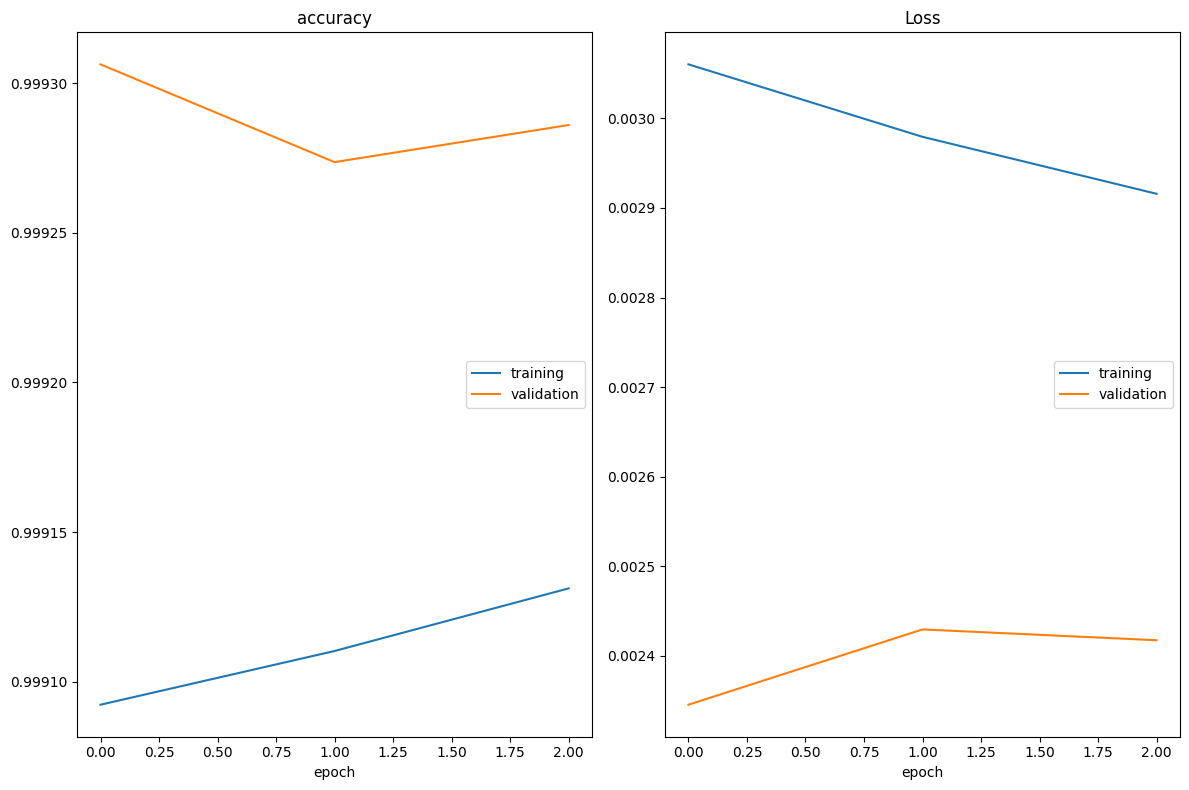

accuracy
	training         	 (min:    0.999, max:    0.999, cur:    0.999)
	validation       	 (min:    0.999, max:    0.999, cur:    0.999)
Loss
	training         	 (min:    0.003, max:    0.003, cur:    0.003)
	validation       	 (min:    0.002, max:    0.002, cur:    0.002)

Epoch 3: val_loss did not improve from 0.00235
1312/1312 [==============================] - 467s 356ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 3: early stopping


In [19]:
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cp_path = f"{config.CHECKPOINT_DIR}weights-{simple_name}-N({len(X_train)})-{latent_dim}.best.hdf5"

# Load weights, if any from previous run
full_model.load_weights(cp_path)

# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(patience=2, monitor="val_loss", mode="min", verbose=1)
plot_loss = PlotLossesKeras()
checkpoint = ModelCheckpoint(
    cp_path, save_weights_only=True, verbose=1, monitor="val_loss", save_best_only=True
)

# Start Training
history = full_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop, plot_loss, checkpoint],
)


## Visualize Metrics

In [20]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


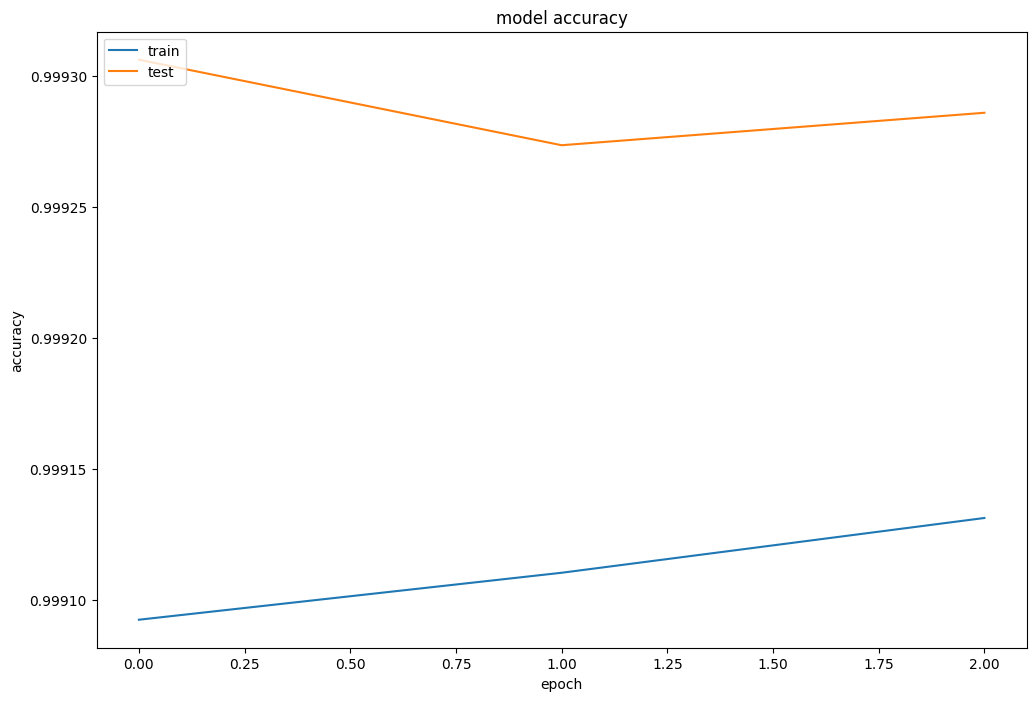

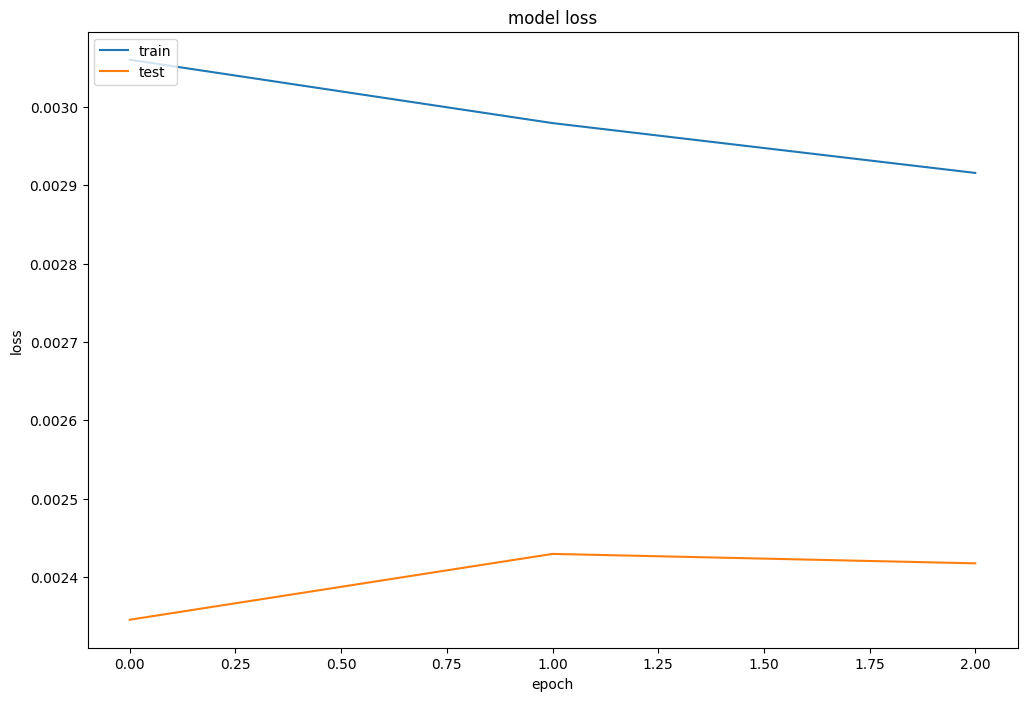

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
full_model.save(f"{config.MODELS_DIR}{simple_name}-N({len(X_train)})-{latent_dim}.best.h5")

# Inference

## Set-up

In [23]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [24]:
def decode_sequence_bigru_attn(
    encoder_model, decoder_model, test_X_seq, num_encoder_tokens, num_decoder_tokens
):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_X_seq: sequence of word ids
    :param num_encoder_tokens: int
    :param num_decoder_tokens: int
    :return:
    """

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(test_X_seq)
    dec_state = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)

    attention_weights = []
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        dec_out, attention, dec_state = decoder_model.predict(
            [enc_outs, dec_state, target_seq]
        )

        # Sample a token
        sampled_token_index = np.argmax(dec_out, axis=-1)[0, 0]
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        attention_weights.append((sampled_token_index, attention))

    return decoded_sentence, attention_weights


In [25]:
def decode_sequence_bilstm_attn(
    encoder_model, decoder_model, test_X_seq, num_encoder_tokens, num_decoder_tokens
):
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    (
        enc_outs,
        enc_fwd_state_h,
        enc_fwd_state_c,
        enc_back_state_h,
        enc_back_state_c,
    ) = encoder_model.predict(test_X_seq)
    encoder_state_h = np.concatenate([enc_fwd_state_h, enc_back_state_h], axis=-1)
    encoder_state_c = np.concatenate([enc_fwd_state_c, enc_back_state_c], axis=-1)

    # The ordering seems significant
    # enc_outs, enc_fwd_state_h, enc_fwd_state_c, enc_back_state_h, enc_back_state_c = encoder_model.predict(test_X_seq)

    attention_weights = []
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        dec_out, attention, dec_state_h, dec_state_c = decoder_model.predict(
            [enc_outs, encoder_state_h, encoder_state_c, target_seq]
        )

        # Sample a token
        sampled_token_index = np.argmax(dec_out[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        attention_weights.append((sampled_token_index, attention))

        # Update states
        encoder_state_h = dec_state_h
        encoder_state_c = dec_state_c

    return decoded_sentence, attention_weights


In [26]:
def decode_sequence_lstm(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [27]:
def plot_attention_weights(
    encoder_inputs, attention_weights, en_id2word, fr_id2word, filename=None
):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print(
            "Your attention weights were empty. No attention map saved to the disk. "
            + "\nPlease check if the decoder produced  a proper translation"
        )
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([fr_id2word[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    y_lab = [
        en_id2word[inp] if inp != 0 else "<Res>"
        for inp in [
            np.argmax(np.squeeze(encoder_inputs)[i])
            for i in range(0, np.squeeze(encoder_inputs).shape[0])
        ]
    ]
    ax.set_yticklabels(y_lab)

    ax.tick_params(labelsize=16)
    ax.tick_params(axis="x", labelrotation=90)

    if not os.path.exists(config.RESULTS_DIR):
        os.mkdir(config.RESULTS_DIR)
    if filename is None:
        plt.savefig(os.path.join(config.RESULTS_DIR, "attention.png"))
    else:
        plt.savefig(os.path.join(config.RESULTS_DIR, "{}".format(filename)))


## From Checkpoint

In [28]:
latent_dim = 44

full_model.load_weights(
    f"{config.CHECKPOINT_DIR}weights-{simple_name}-N({len(X_train)})-{latent_dim}.best.hdf5"
)
loaded_model = full_model


### LSTM

In [31]:
# encoder_inputs = Input(shape=(None, num_encoder_tokens))
# encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_model = Model(encoder_inputs, [state_h, state_c])

# decoder_inputs = Input(shape=(None, num_decoder_tokens))

# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_outputs, state_h, state_c = decoder_lstm(
#     decoder_inputs, initial_state=decoder_states_inputs
# )
# decoder_states = [state_h, state_c]
# decoder_outputs = decoder_dense(decoder_outputs)
# decoder_model = Model(
#     [decoder_inputs] + decoder_states_inputs, 
#     [decoder_outputs] + decoder_states
# )

### Bi-GRU + Attention

In [34]:
# """ Encoder (Inference) model """
# encoder_inf_inputs = Input(shape=(None, num_encoder_tokens), name="encoder_inf_inputs")
# encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(
#     encoder_inf_inputs
# )
# encoder_model = Model(
#     inputs=encoder_inf_inputs,
#     outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state],
# )

# """ Decoder (Inference) model """
# decoder_inf_inputs = Input(shape=(None, num_decoder_tokens), name="decoder_inf_inputs")
# encoder_inf_states = Input(
#     batch_shape=(None, None, 2 * latent_dim), name="encoder_inf_states"
# )
# decoder_init_state = Input(batch_shape=(None, 2 * latent_dim), name="decoder_init")

# decoder_inf_out, decoder_inf_state = decoder_gru(
#     decoder_inf_inputs, initial_state=decoder_init_state
# )
# attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
# decoder_inf_concat = Concatenate(axis=-1, name="concat")(
#     [decoder_inf_out, attn_inf_out]
# )
# decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
# decoder_model = Model(
#     inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
#     outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state],
# )

### Bi-LSTM + Attention

In [35]:
""" Encoder (Inference) model """
encoder_inf_inputs = Input(shape=(None, num_encoder_tokens), name="encoder_inf_inputs")
(
    encoder_inf_out,
    encoder_inf_fwd_state_h,
    encoder_inf_fwd_state_c,
    encoder_inf_back_state_h,
    encoder_inf_back_state_c,
) = encoder_lstm(encoder_inf_inputs)
encoder_model = Model(
    inputs=encoder_inf_inputs,
    outputs=[
        encoder_inf_out,
        encoder_inf_fwd_state_h,
        encoder_inf_fwd_state_c,
        encoder_inf_back_state_h,
        encoder_inf_back_state_c,
    ],
)

""" Decoder (Inference) model """
decoder_inf_inputs = Input(shape=(None, num_decoder_tokens), name="decoder_inf_inputs")
encoder_inf_states = Input(
    batch_shape=(None, None, 2 * latent_dim), name="encoder_inf_states"
)

decoder_state_input_h = Input(batch_shape=(None, 2 * latent_dim))
decoder_state_input_c = Input(batch_shape=(None, 2 * latent_dim))

decoder_init_state = [decoder_state_input_h, decoder_state_input_c]

decoder_inf_out, decoder_inf_state_h, decoder_inf_state_c = decoder_lstm(
    decoder_inf_inputs, initial_state=decoder_init_state
)

attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1, name="concat")(
    [decoder_inf_out, attn_inf_out]
)
decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)

decoder_model = Model(
    inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
    outputs=[
        decoder_inf_pred,
        attn_inf_states,
        decoder_inf_state_h,
        decoder_inf_state_c,
    ],
)

## From Saved HDF5

In [38]:
from tensorflow.keras.models import load_model

# Set these parameters (embedded in file name)
latent_dim = 44

loaded_model = load_model(
    f"{config.MODELS_DIR}{simple_name}-N({len(X_train)})-{latent_dim}.best.h5",
    custom_objects={"AttentionLayer": AttentionLayer},
)

In [39]:
print(loaded_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 39)]   0           []                               
                                                                                                  
 bidirectional_encoder (Bidirec  [(None, None, 88),  29568       ['input_7[0][0]']                
 tional)                         (None, 44),                                                      
                                 (None, 44),                                                      
                                 (None, 44),                                                      
                                 (None, 44)]                                                      
                                                                                            

### LSTM

In [ ]:
# encoder_inputs = Input(shape=(None, num_encoder_tokens))
# encoder = loaded_model.layers[2]
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# encoder_model = Model(encoder_inputs, [state_h, state_c])

# decoder_inputs = Input(shape=(None, num_decoder_tokens))
# decoder_dense = loaded_model.layers[4]

# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_lstm = loaded_model.layers[3]
# decoder_outputs, state_h, state_c = decoder_lstm(
#     decoder_inputs, initial_state=decoder_states_inputs
# )
# decoder_states = [state_h, state_c]
# decoder_outputs = decoder_dense(decoder_outputs)
# decoder_model = Model(
#     [decoder_inputs] + decoder_states_inputs, 
#     [decoder_outputs] + decoder_states
# )

### Bi-GRU + Attention

In [ ]:
# encoder_inf_inputs = Input(shape=(None, num_encoder_tokens), name="encoder_inf_inputs")
# encoder = full_model.layers[1]
# encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder(
#     encoder_inf_inputs
# )
# encoder_model = Model(
#     inputs=encoder_inf_inputs,
#     outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state],
# )

# """ Decoder (Inference) model """
# decoder_inf_inputs = Input(shape=(None, num_decoder_tokens), name="decoder_inf_inputs")
# encoder_inf_states = Input(
#     batch_shape=(None, None, 2 * latent_dim), name="encoder_inf_states"
# )
# decoder_init_state = Input(batch_shape=(None, 2 * latent_dim), name="decoder_init")

# decoder = full_model.layers[4]
# dense = full_model.layers[7]
# decoder_inf_out, decoder_inf_state = decoder(
#     decoder_inf_inputs, initial_state=decoder_init_state
# )
# attn_layer = full_model.layers[5]
# attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
# decoder_inf_concat = Concatenate(axis=-1, name="concat")(
#     [decoder_inf_out, attn_inf_out]
# )
# decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
# decoder_model = Model(
#     inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
#     outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state],
# )

1/1 [==============================] - 0s 15ms/step
-
Input sentence: he likes cats and dogs
Decoded sentence: 'exists x1.(exists x2.(_cat(x2) & _like(x1,x2)) & exists x3.(_dog(x3) & _like(x1,x3)))'
Real sentence: 'exists x1.(_noteworthy(x1) | _unique(x1))'
INCORRECT
Completed: 25.0%
1/4
Accuracy:
0.0%
1/1 [==============================] - 0s 14ms/step
-
Input sentence: failed to get next element hresult 0x800f080d - cbs e manifest invalid item
Decoded sentence: 'exists x1.(exists x2.(_ext0p(x2) & (x1 = x2)) -> exists x3.(_item(x3) & _ext(x1,x3))) -exists x3.(_get(x3) & _ext(x1,x3)))'
Real sentence: 'exists x1.(_people(x1) & _stupid(x1))'
INCORRECT
Completed: 50.0%
2/4
Accuracy:
0.0%
1/1 [==============================] - 0s 15ms/step
-
Input sentence: warning unrecognized packageextended attribute
Decoded sentence: 'exists x1 x2.(_attribute(x2) & _packageextend(x1,x2) & exists x3.(_attribute(x3) & _unrecognize(x1,x3)))'
Real sentence: 'exists x1.(_agile(x1) & _manoeuvrable(x1))'
INCO

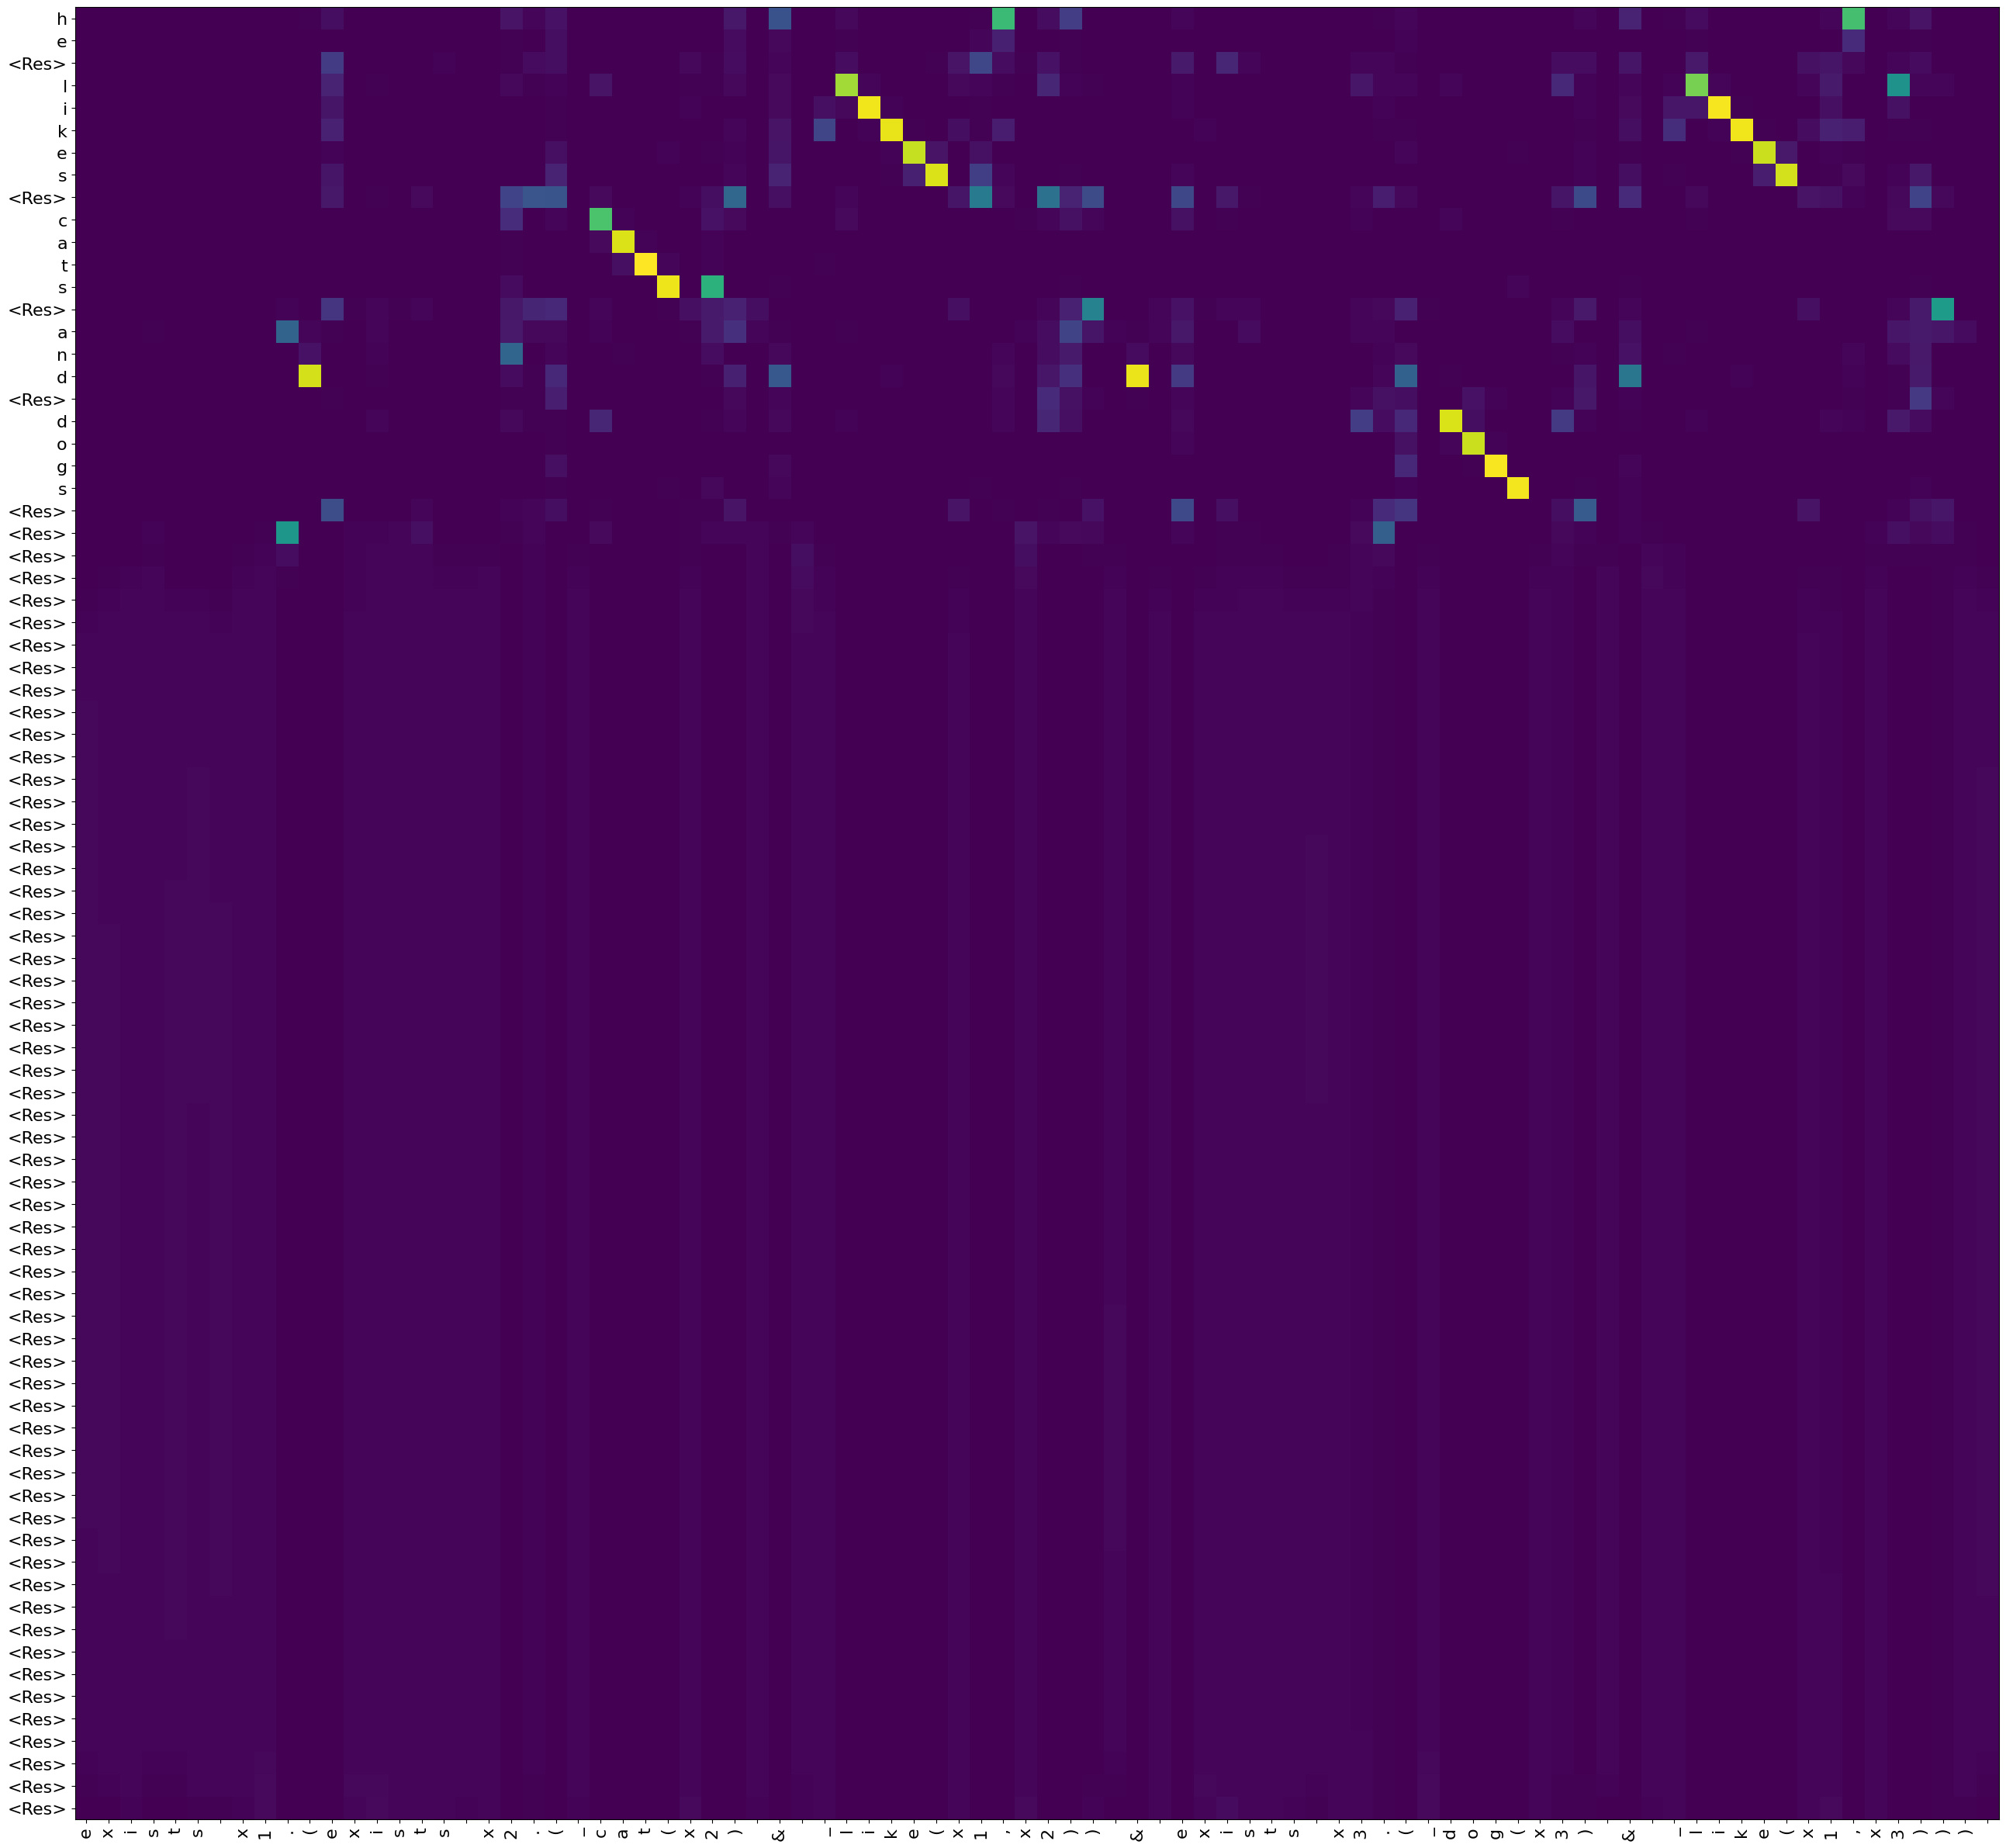

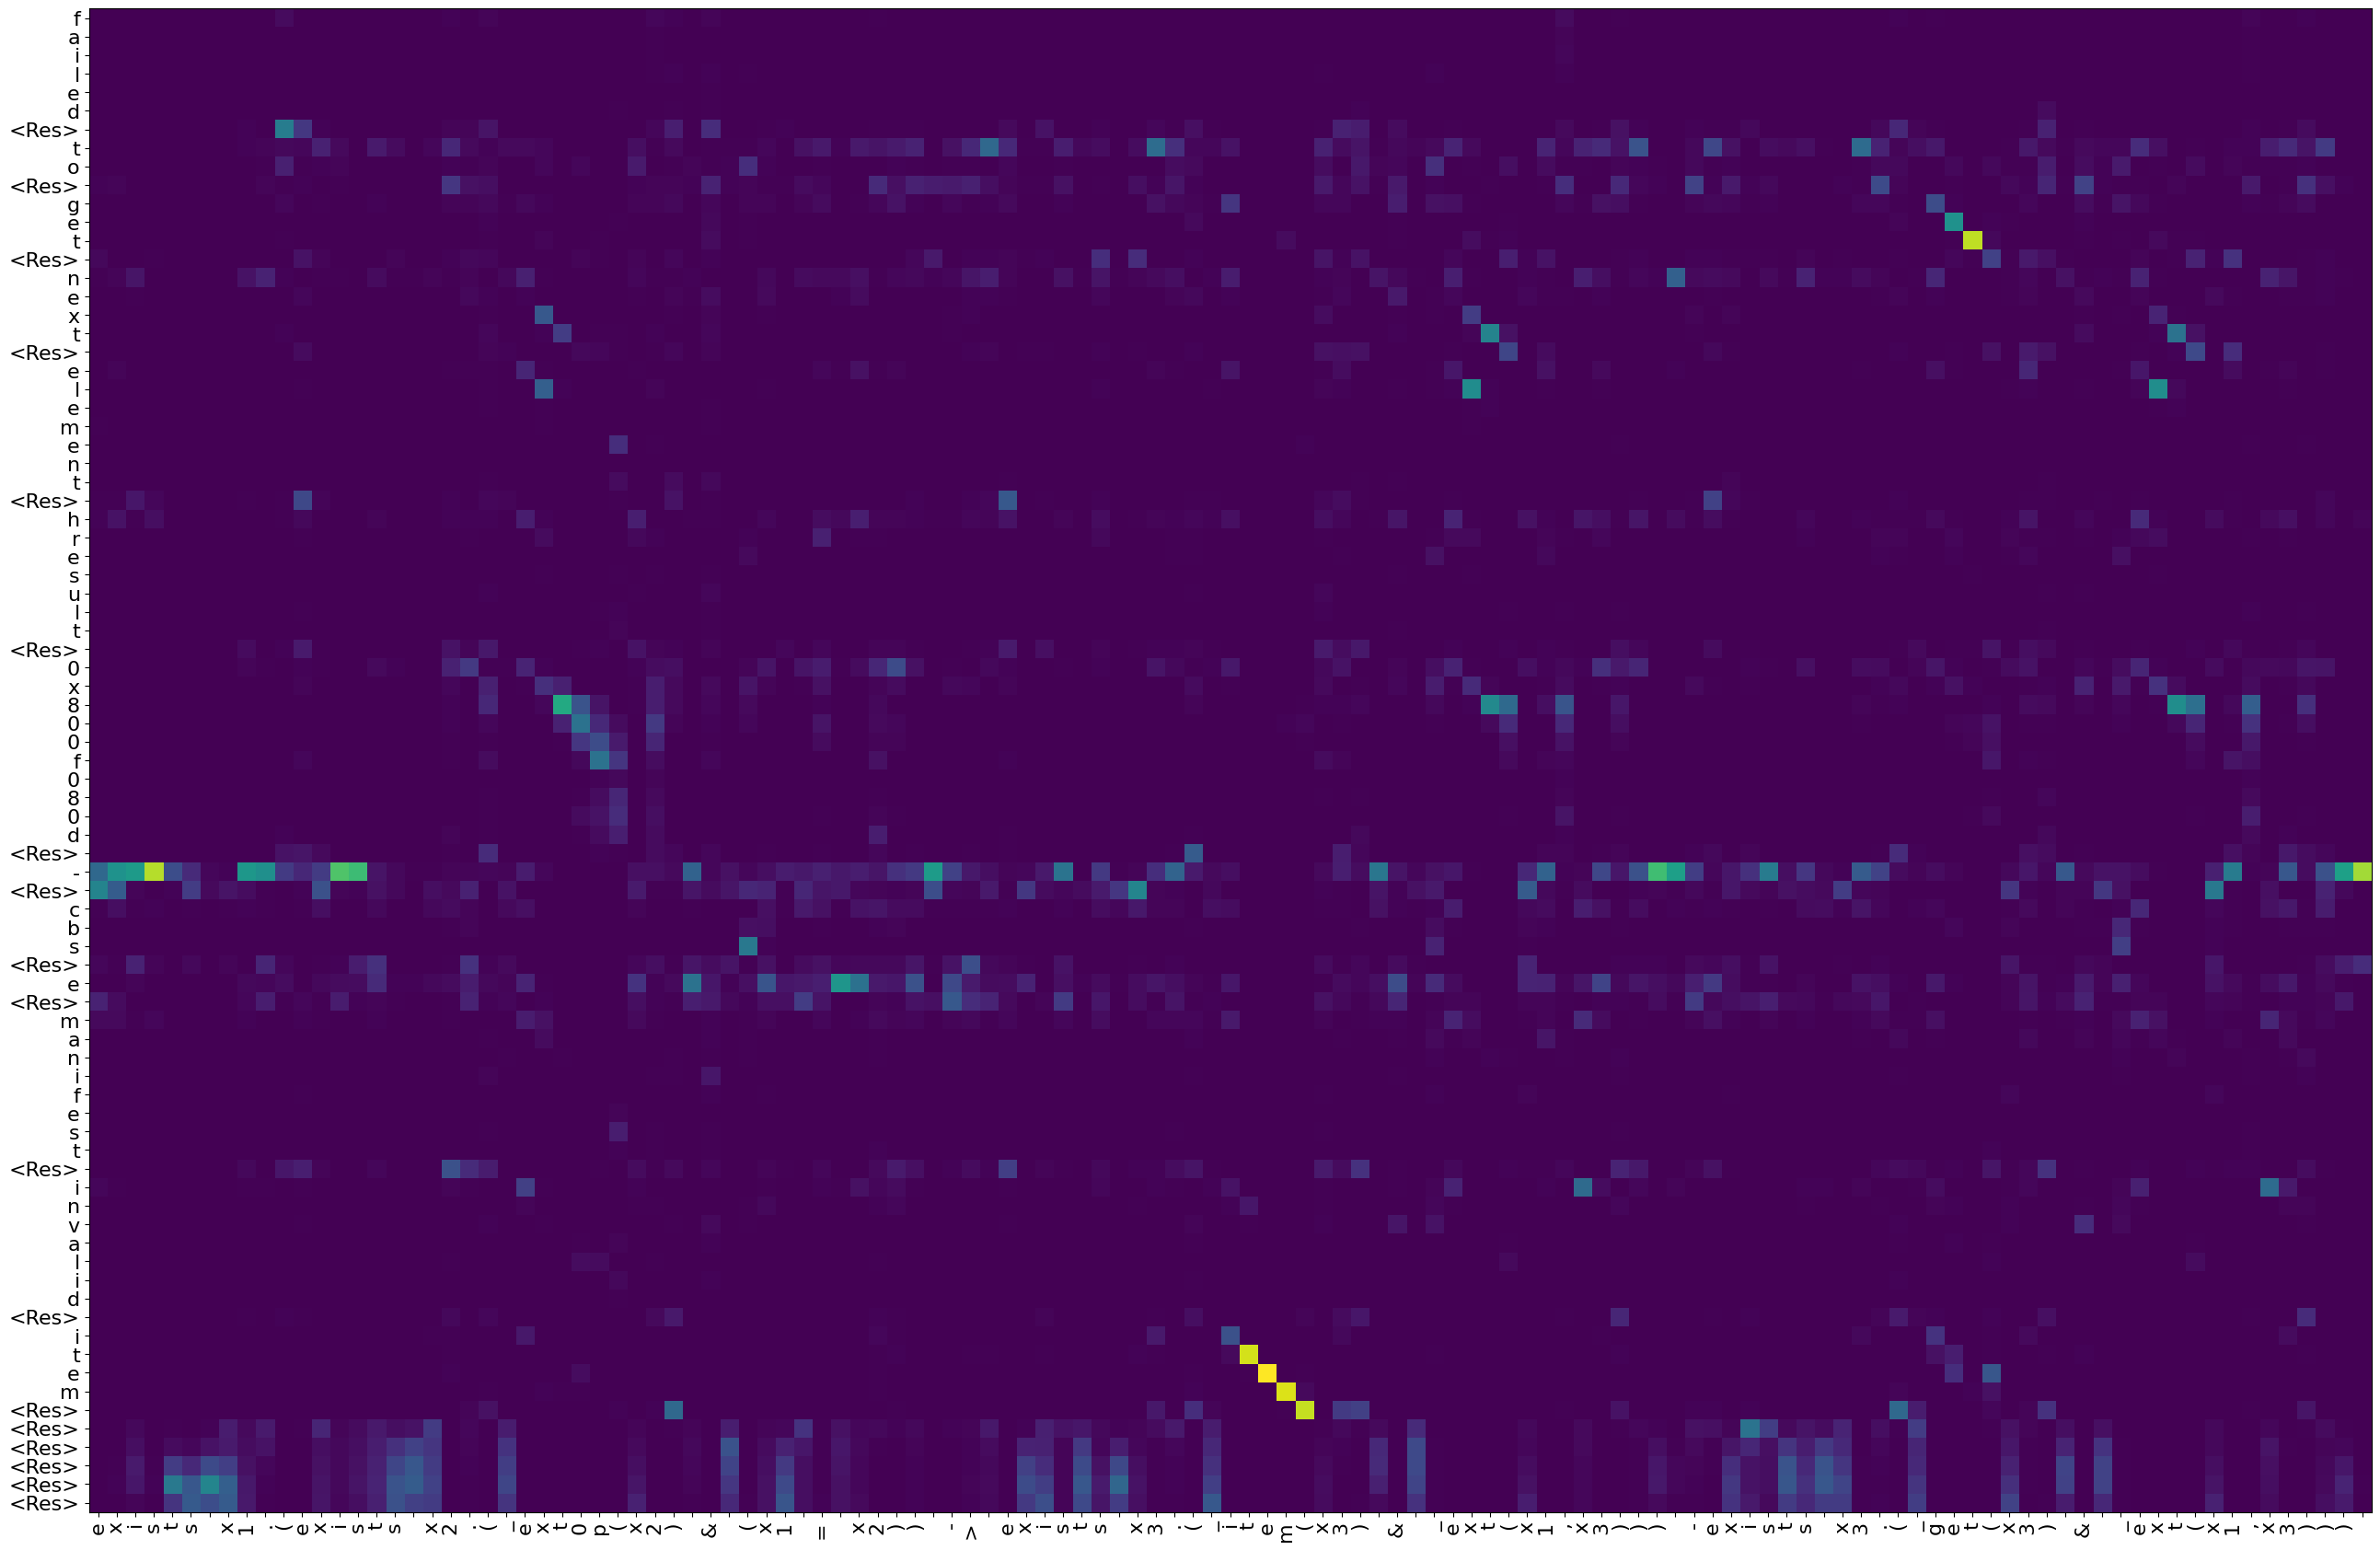

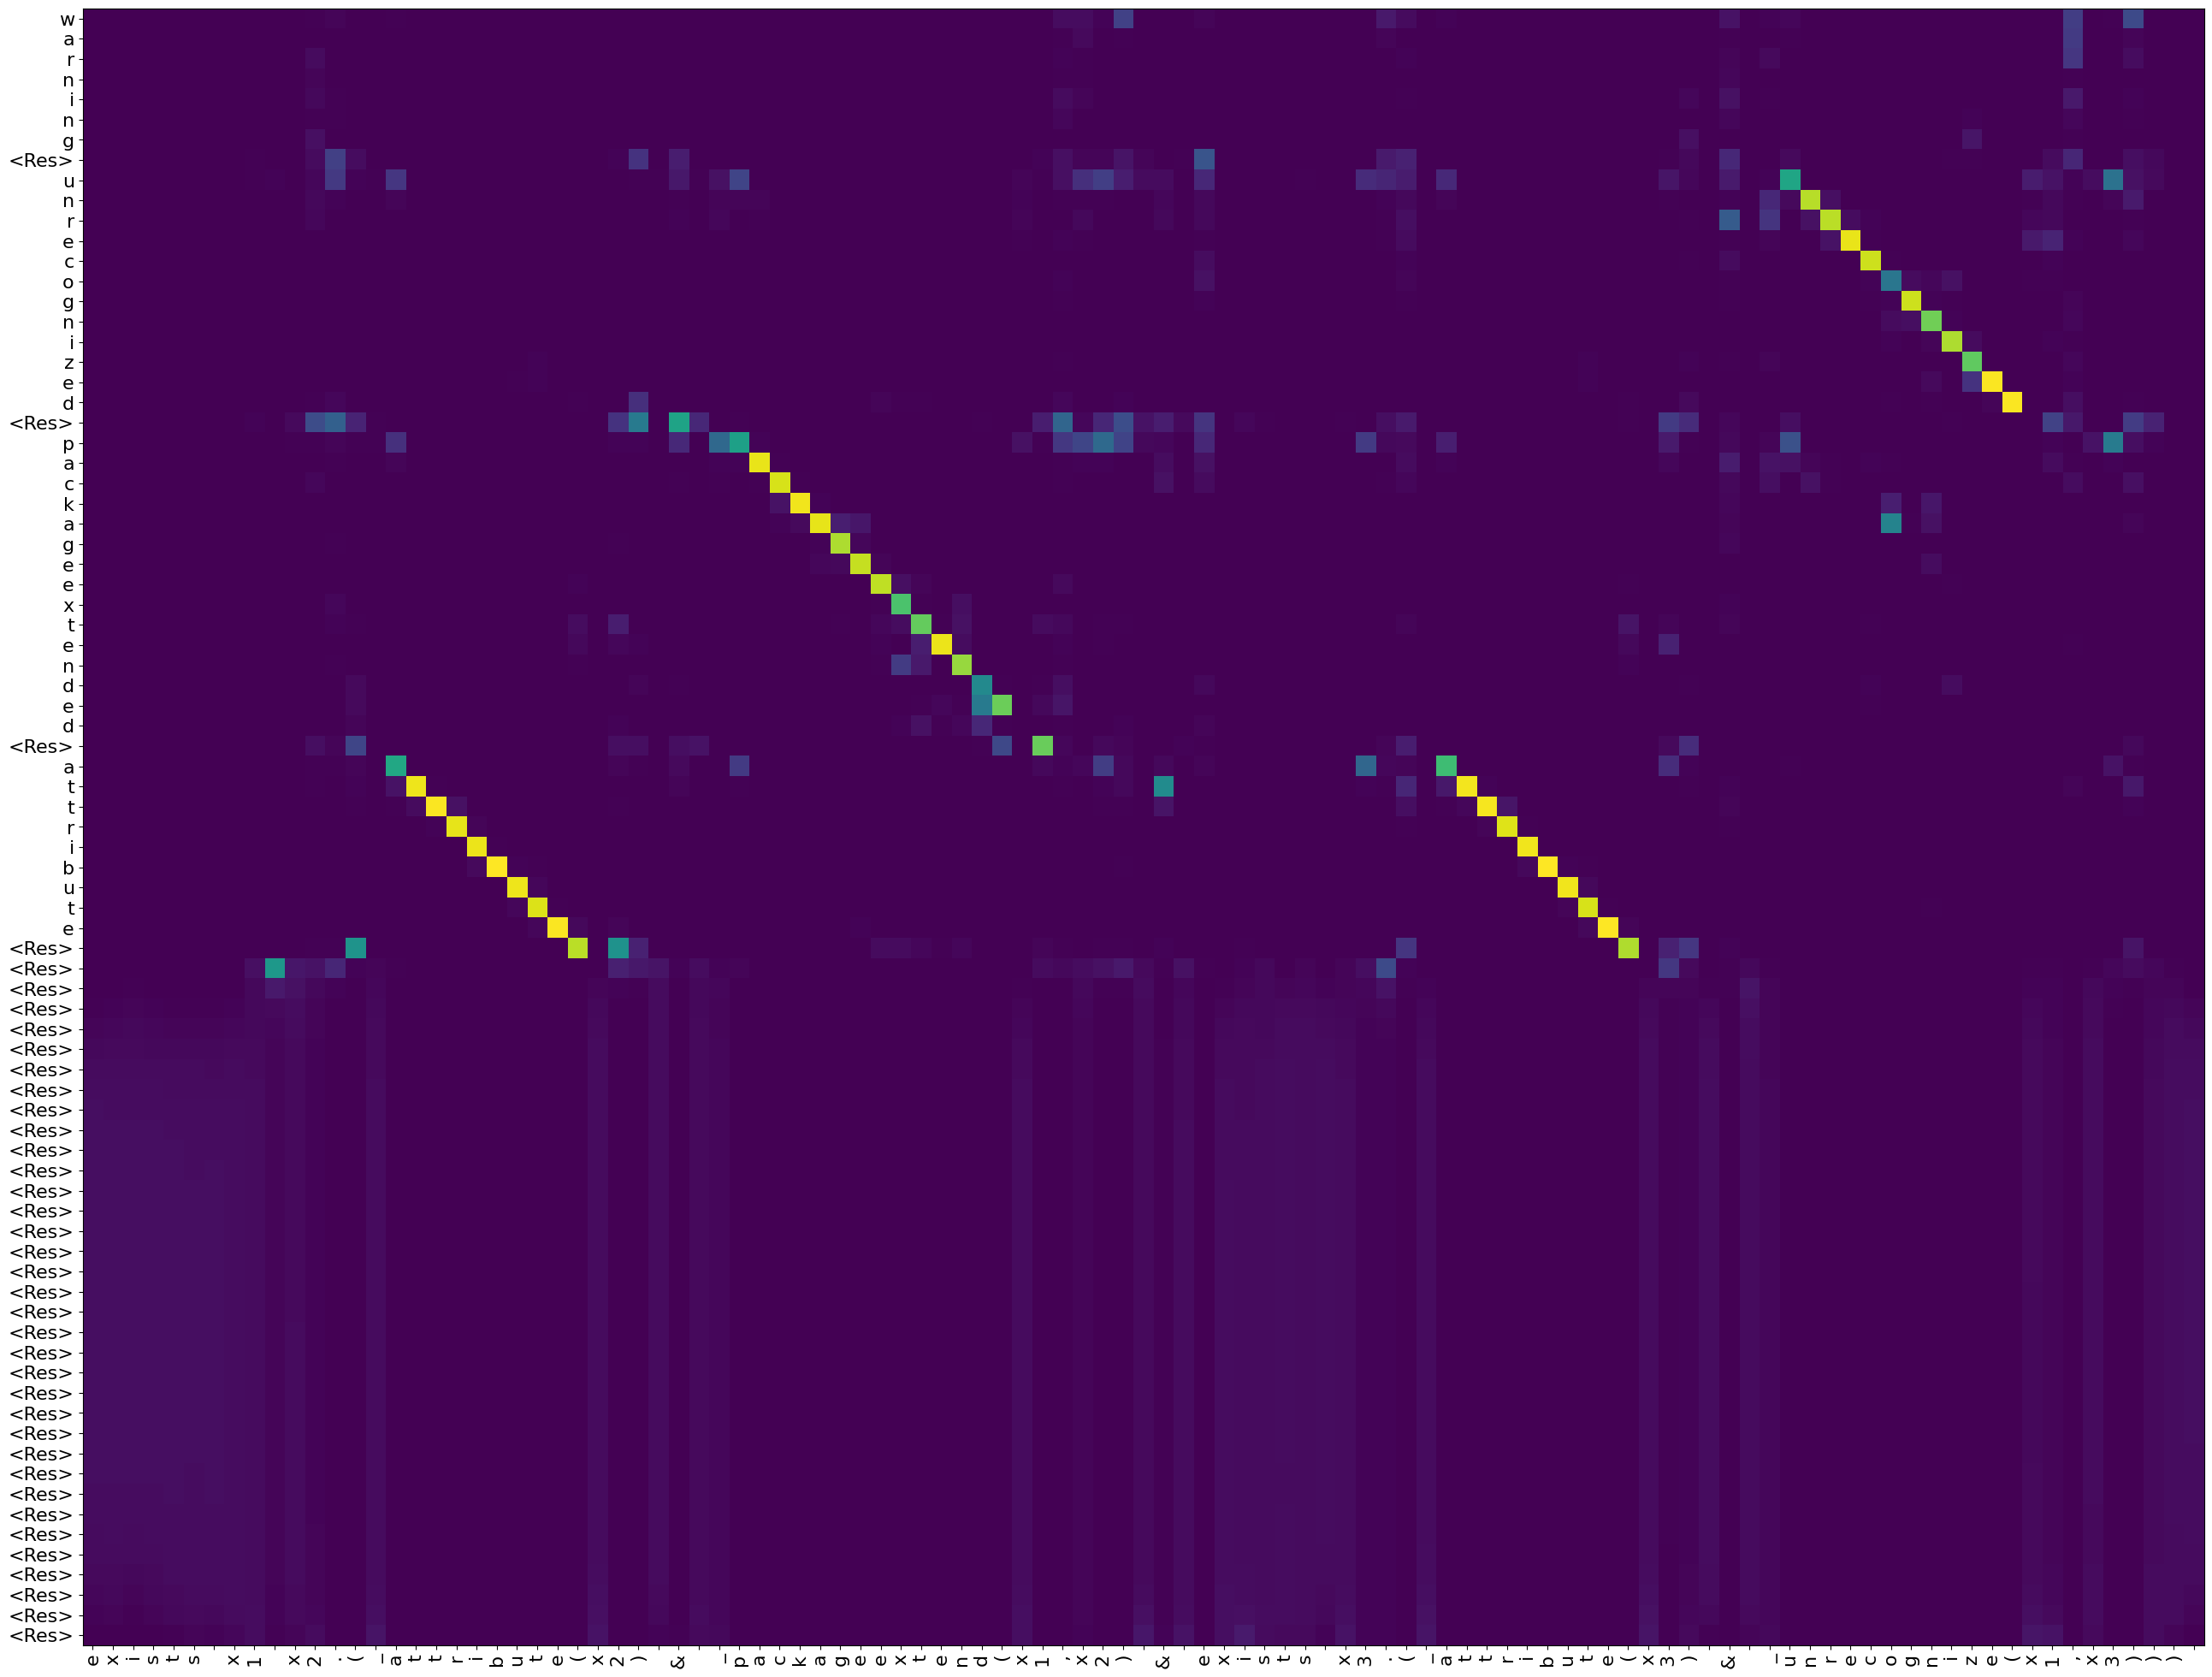

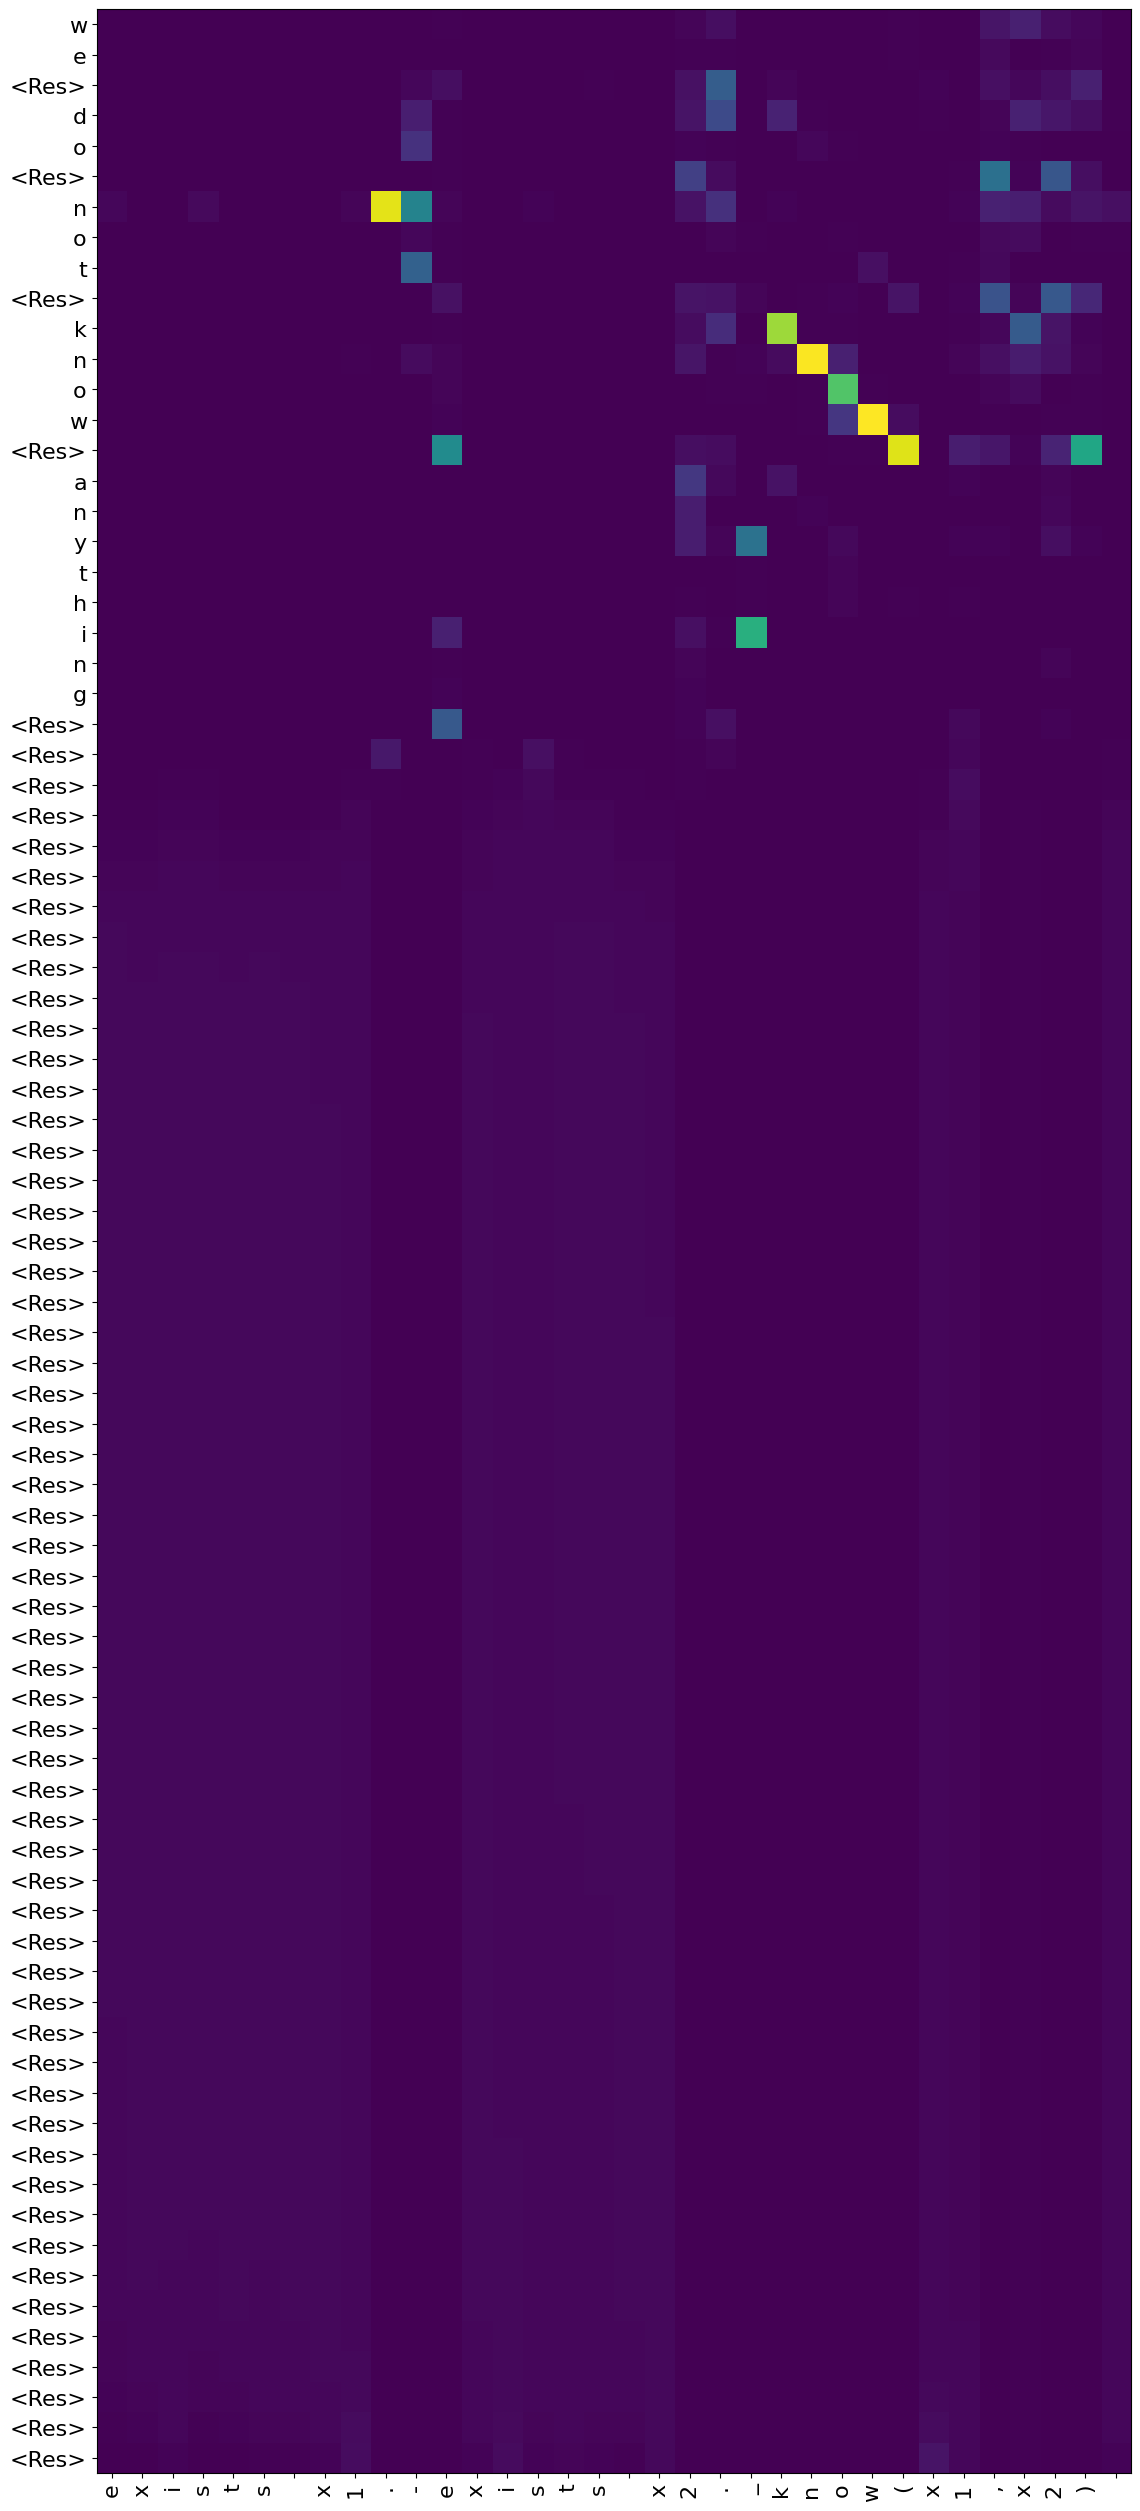

In [49]:
# X_test = ['he likes cats and dogs']
X_test = ["he likes cats and dogs","failed to get next element hresult 0x800f080d - cbs e manifest invalid item","warning unrecognized packageextended attribute","we do not know anything"]

encoder_test_data = np.zeros(
    (len(X_test), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
for i, x in enumerate(X_test):
    for t, char in enumerate(x):
        encoder_test_data[i, t, input_token_index[char]] = 1.0
    encoder_test_data[i, t + 1 :, input_token_index[" "]] = 1.0

import sys

np.set_printoptions(threshold=sys.maxsize)

correct = 0
checked = 0
for seq_index in range(0, len(X_test)):
    test_X = X_test[seq_index]
    input_seq = encoder_test_data[seq_index : seq_index + 1]

    # Bi-LSTM
    decoded_sentence, attn_weights = decode_sequence_bilstm_attn(
        encoder_model, decoder_model, input_seq, num_encoder_tokens, num_decoder_tokens
    )

    # LSTM
    # decoded_sentence = decode_sequence_lstm(input_seq)
    plot_attention_weights(
        input_seq,
        attn_weights,
        reverse_input_char_index,
        reverse_target_char_index,
        filename="attention_{}.png".format(seq_index),
    )
    print("-")
    print("Input sentence:", X_test[seq_index])
    print("Decoded sentence:", repr(decoded_sentence.rstrip()))
    print("Real sentence:", repr(y_test[seq_index]))
    print("CORRECT" if decoded_sentence.rstrip() == y_test[seq_index] else "INCORRECT")
    correct += 1 if decoded_sentence.rstrip() == y_test[seq_index] else 0
    checked += 1
    print(f"Completed: {(checked / len(X_test)) * 100}%")
    print(f"{checked}/{len(X_test)}")
    print("Accuracy:")
    print(f"{(correct / checked) * 100}%")


1/1 [==============================] - 0s 15ms/step
-
Input sentence: he likes cats and dogs
Decoded sentence: 'exists x1.(exists x2.(_cat(x2) & _like(x1,x2)) & exists x3.(_dog(x3) & _like(x1,x3)))'
Real sentence: 'exists x1.(_noteworthy(x1) | _unique(x1))'
INCORRECT
Completed: 33.33333333333333%
1/3
Accuracy:
0.0%
1/1 [==============================] - 0s 14ms/step
-
Input sentence: failed to get next element hresult 0x800f080d - cbs e manifest invalid item
Decoded sentence: 'exists x1.(exists x2.(_ext0p(x2) & (x1 = x2)) -> exists x3.(_item(x3) & _ext(x1,x3))) -exists x3.(_get(x3) & _ext(x1,x3)))'
Real sentence: 'exists x1.(_people(x1) & _stupid(x1))'
INCORRECT
Completed: 66.66666666666666%
2/3
Accuracy:
0.0%
1/1 [==============================] - 0s 14ms/step
-
Input sentence: warning unrecognized packageextended attribute
Decoded sentence: 'exists x1 x2.(_attribute(x2) & _packageextend(x1,x2) & exists x3.(_attribute(x3) & _unrecognize(x1,x3)))'
Real sentence: 'exists x1.(_agile(x1) 

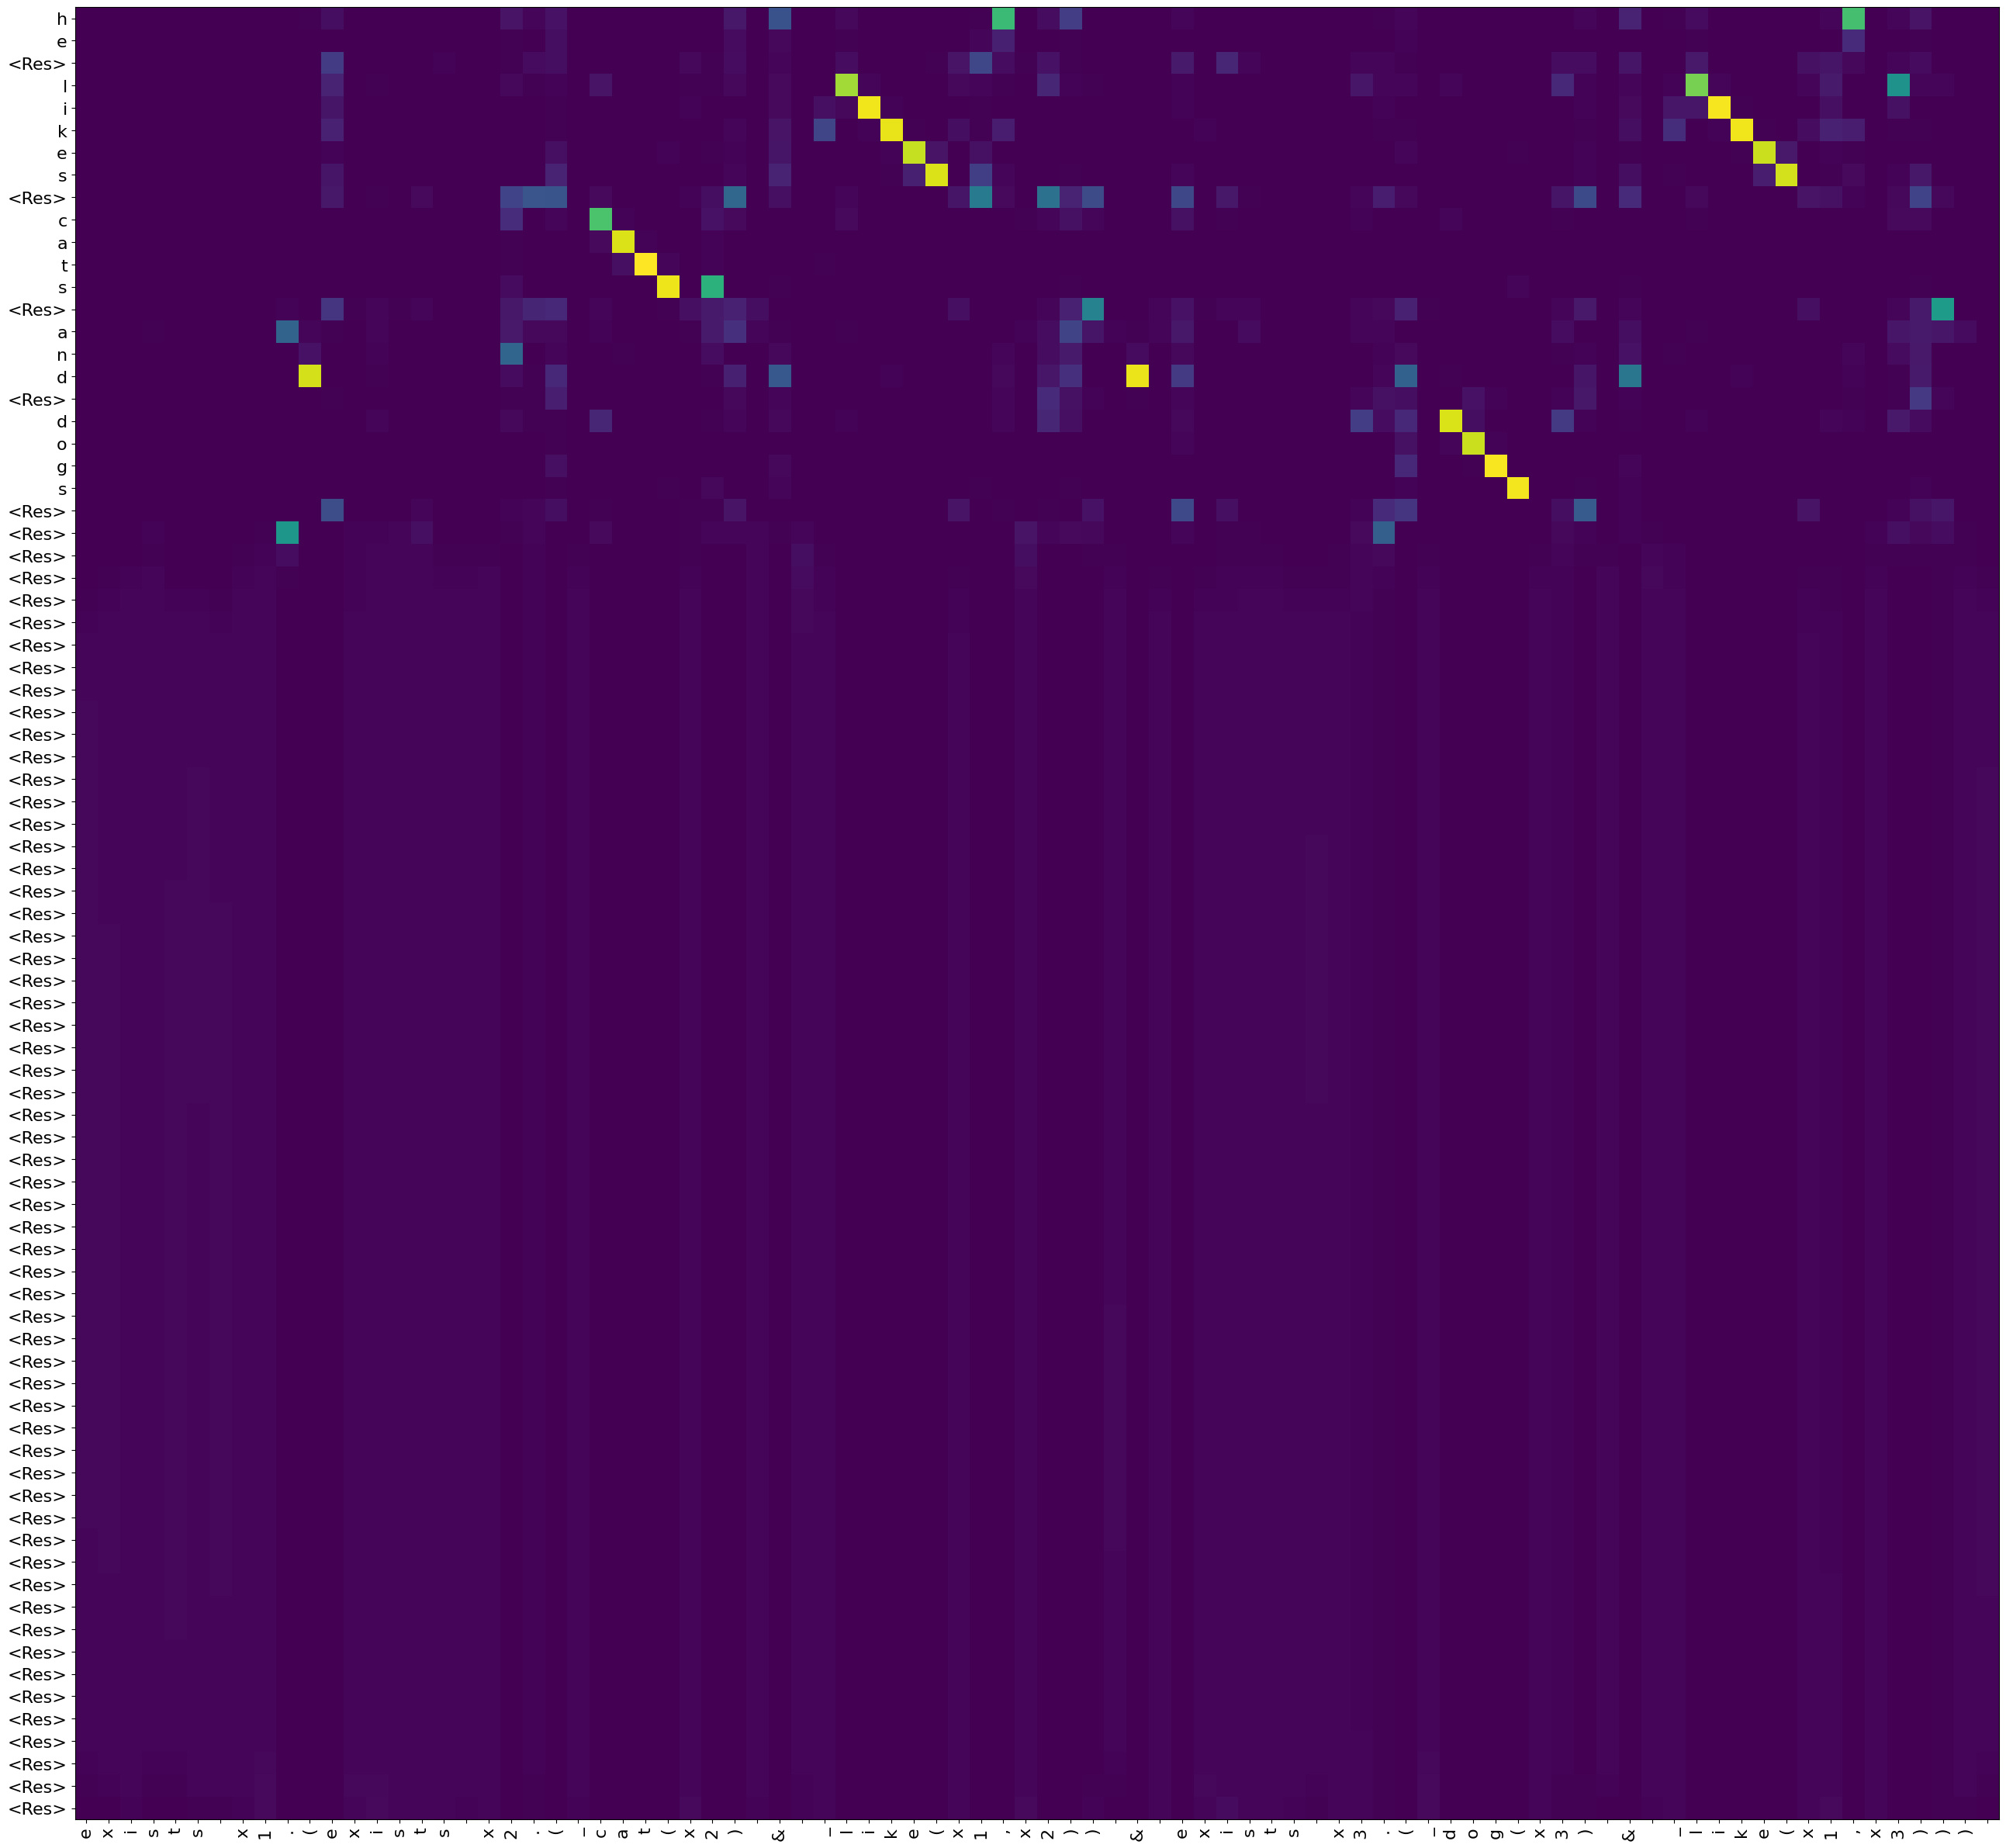

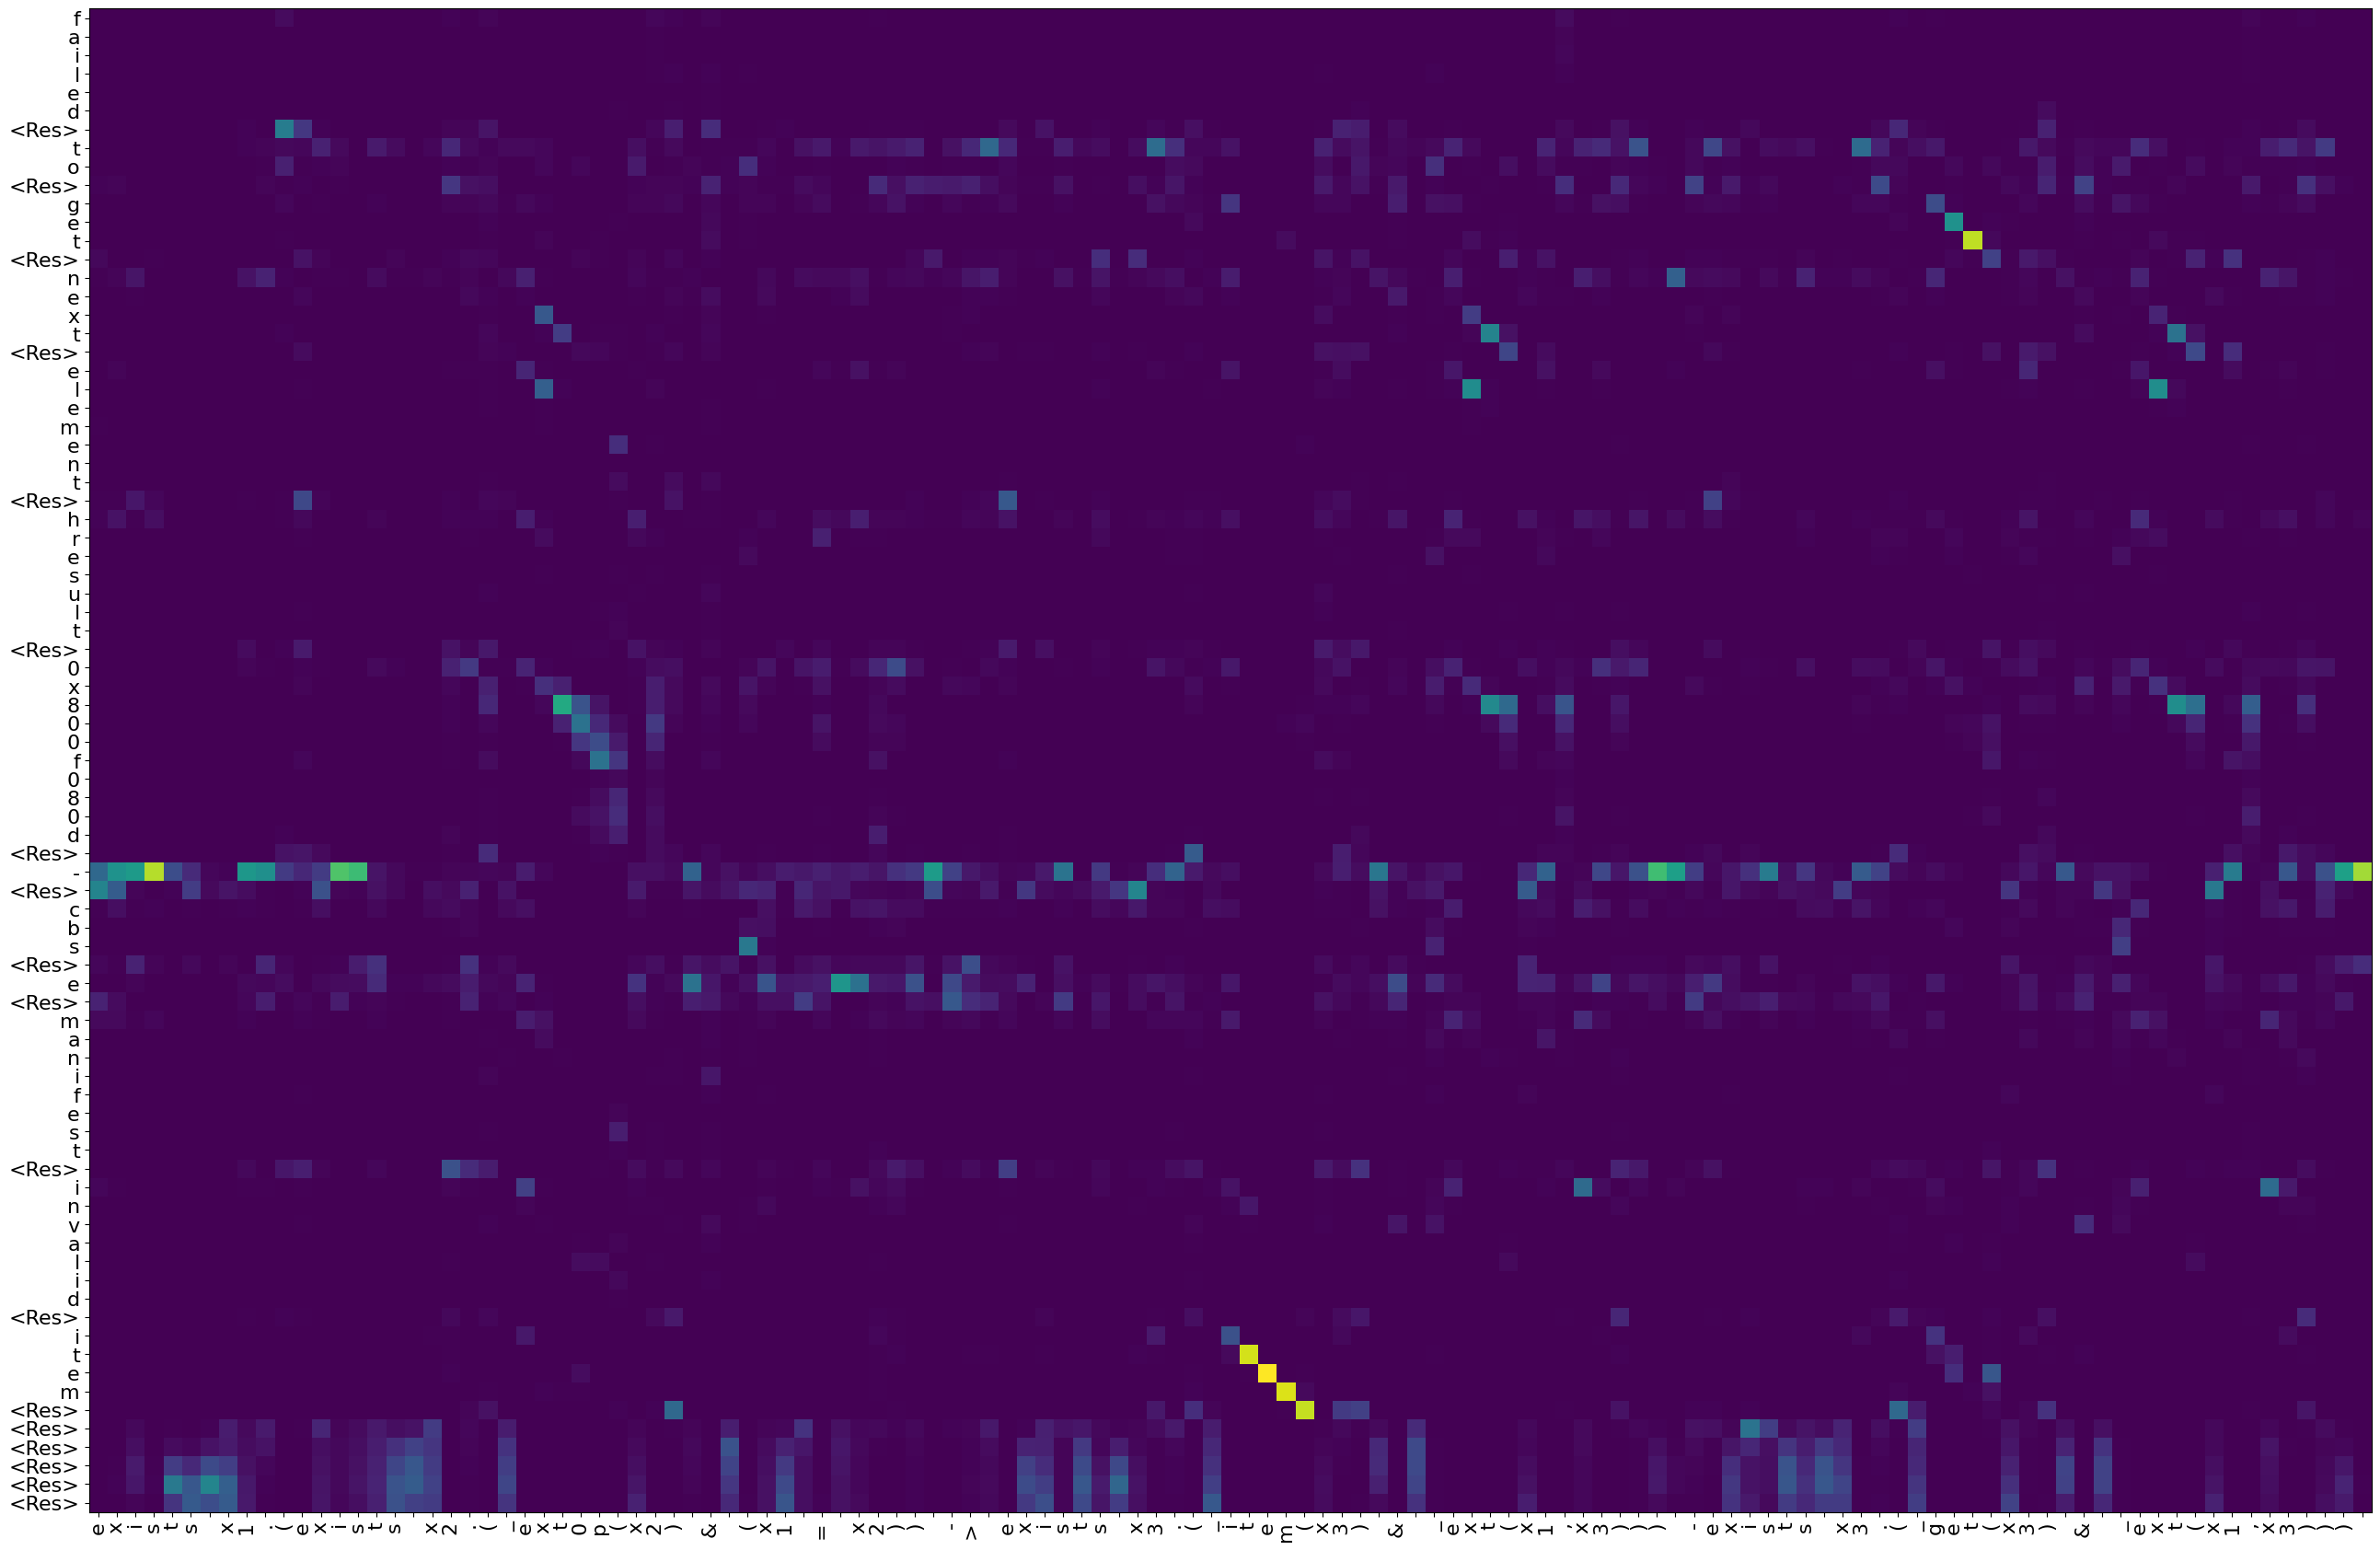

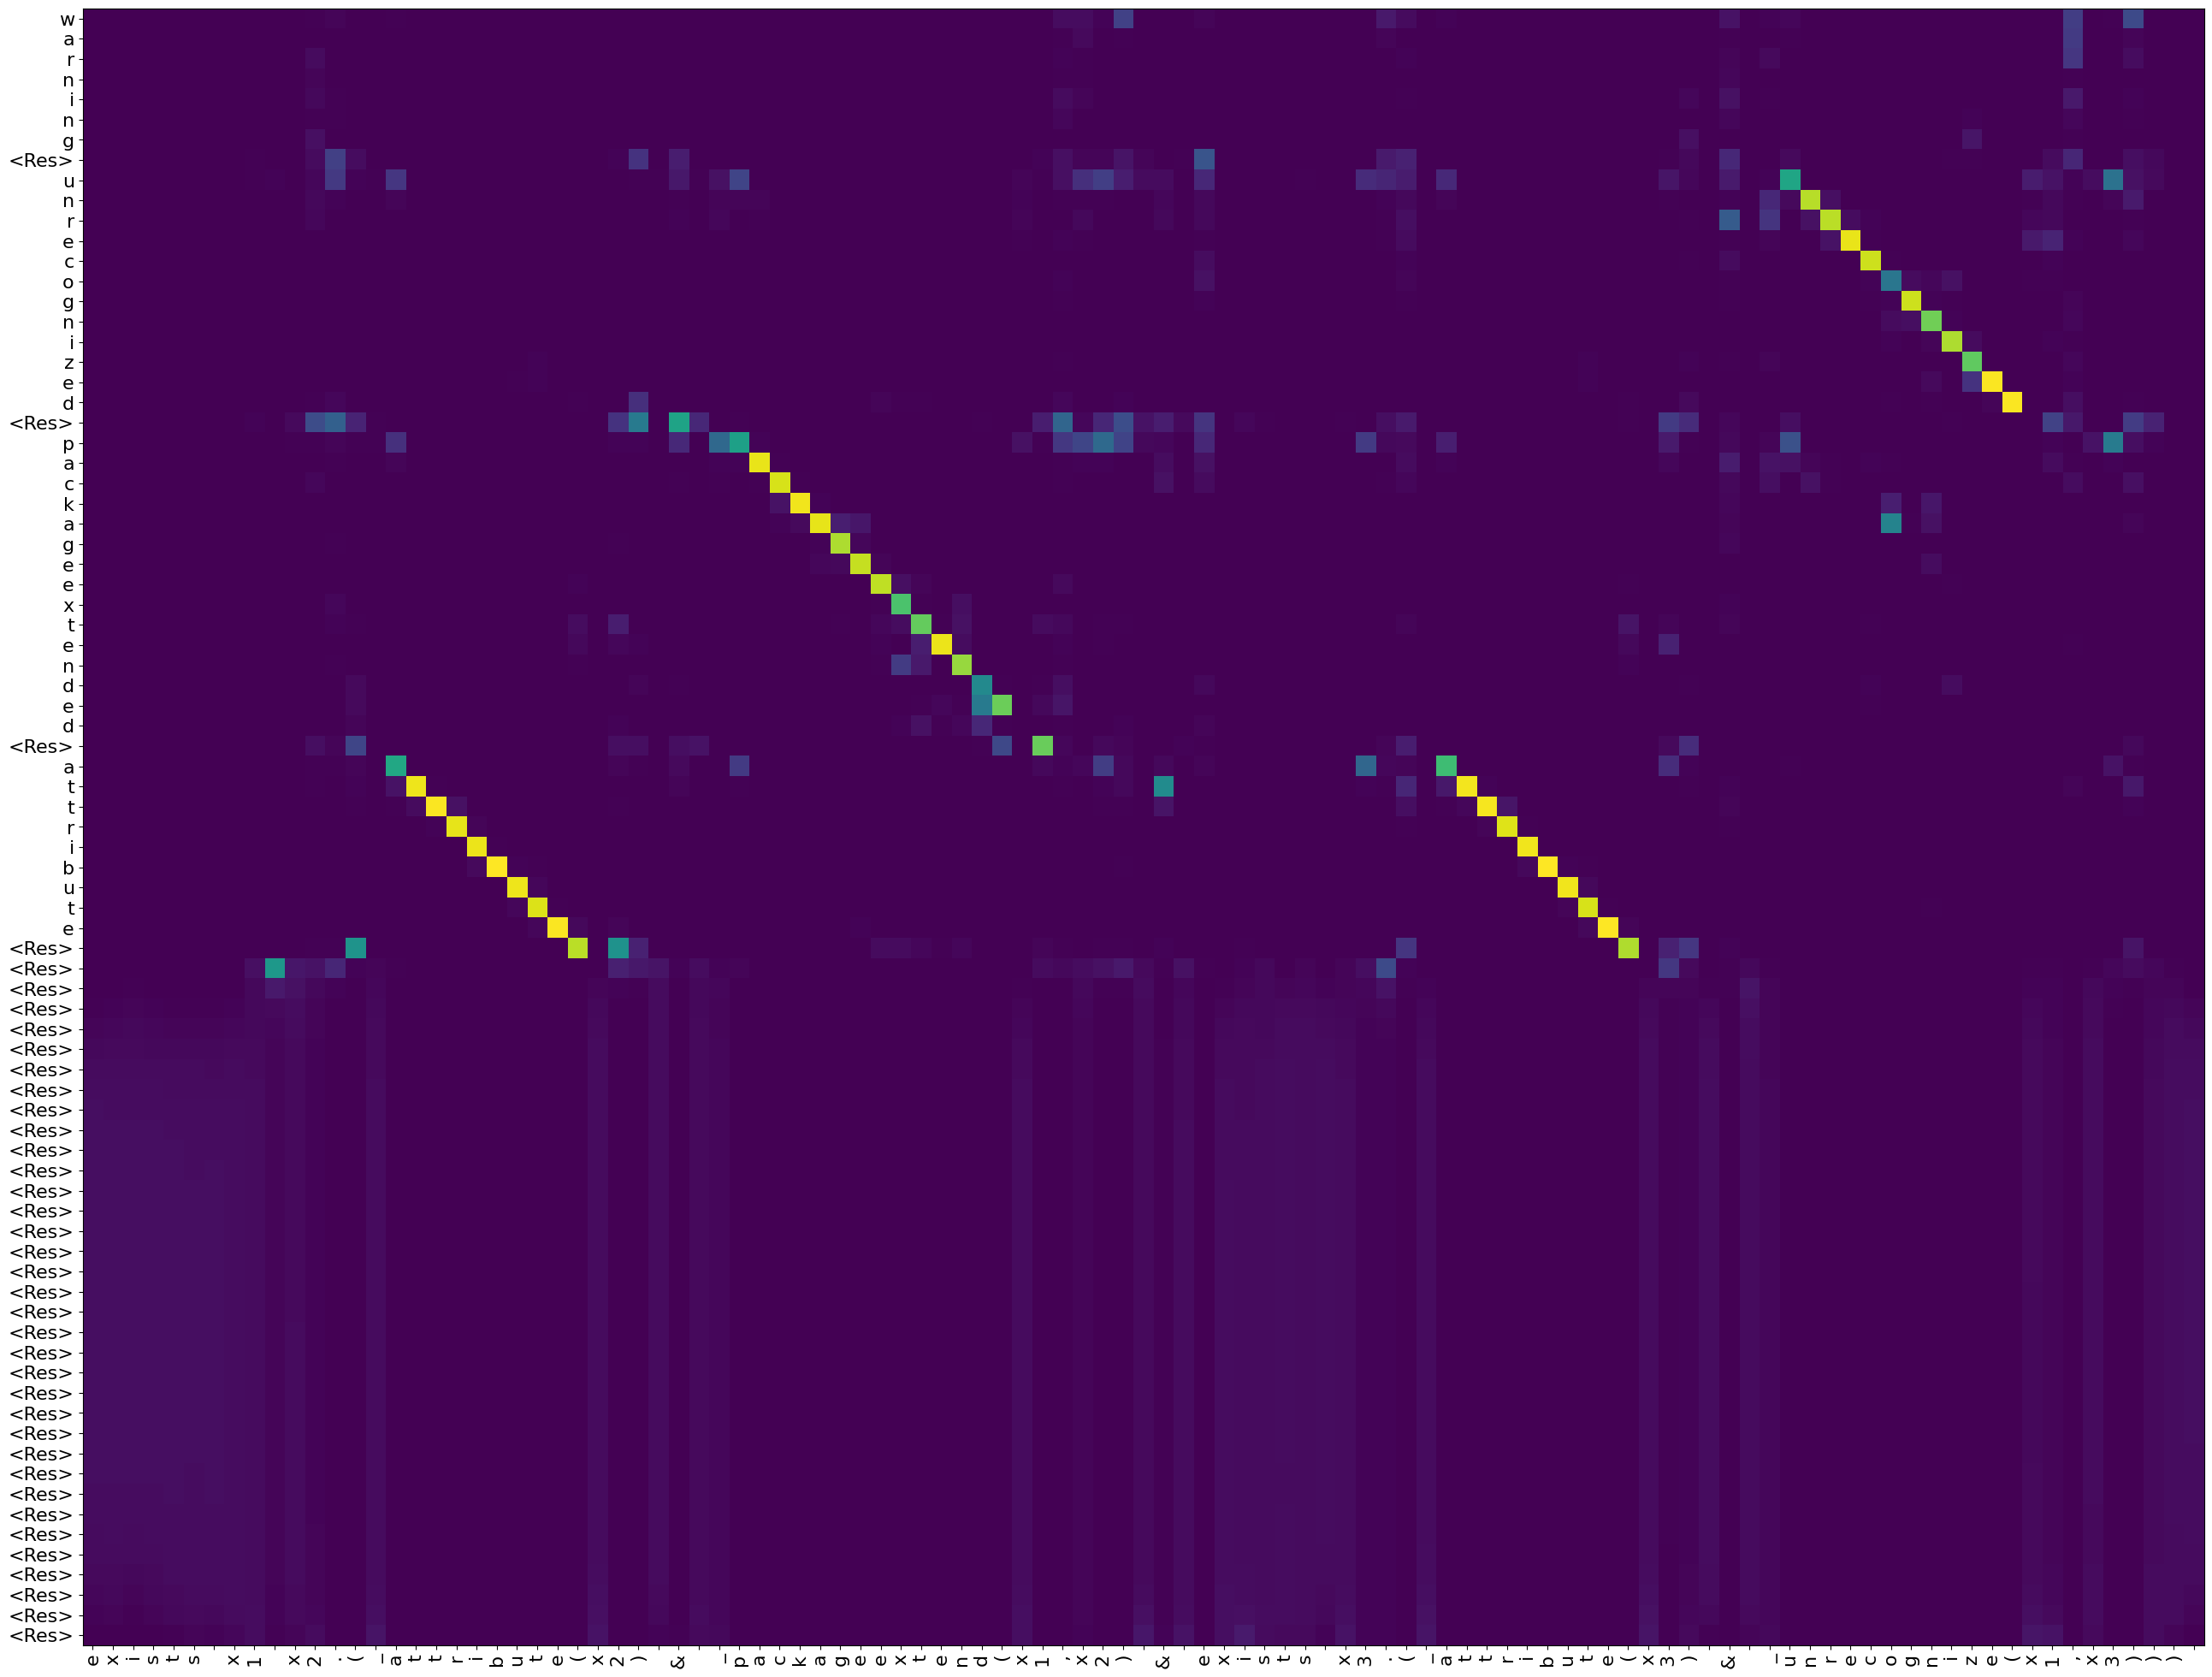

In [48]:
# X_test = ['he likes cats and dogs']
X_test = ["he likes cats and dogs","failed to get next element hresult 0x800f080d - cbs e manifest invalid item","warning unrecognized packageextended attribute"]

encoder_test_data = np.zeros(
    (len(X_test), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
for i, x in enumerate(X_test):
    for t, char in enumerate(x):
        encoder_test_data[i, t, input_token_index[char]] = 1.0
    encoder_test_data[i, t + 1 :, input_token_index[" "]] = 1.0

import sys

np.set_printoptions(threshold=sys.maxsize)

correct = 0
checked = 0
for seq_index in range(0, len(X_test)):
    test_X = X_test[seq_index]
    input_seq = encoder_test_data[seq_index : seq_index + 1]

    # Bi-LSTM
    decoded_sentence, attn_weights = decode_sequence_bilstm_attn(
        encoder_model, decoder_model, input_seq, num_encoder_tokens, num_decoder_tokens
    )

    # LSTM
    # decoded_sentence = decode_sequence_lstm(input_seq)
    plot_attention_weights(
        input_seq,
        attn_weights,
        reverse_input_char_index,
        reverse_target_char_index,
        filename="attention_{}.png".format(seq_index),
    )
    print("-")
    print("Input sentence:", X_test[seq_index])
    print("Decoded sentence:", repr(decoded_sentence.rstrip()))
    print("Real sentence:", repr(y_test[seq_index]))
    print("CORRECT" if decoded_sentence.rstrip() == y_test[seq_index] else "INCORRECT")
    correct += 1 if decoded_sentence.rstrip() == y_test[seq_index] else 0
    checked += 1
    print(f"Completed: {(checked / len(X_test)) * 100}%")
    print(f"{checked}/{len(X_test)}")
    print("Accuracy:")
    print(f"{(correct / checked) * 100}%")


## On Test Data